In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import itertools
import time
from collections import Counter
import hdbscan
## get that here: https://github.com/scikit-learn-contrib/hdbscan

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics

from sqlalchemy import create_engine
import datetime 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib
pd.options.display.max_columns=300
pd.options.display.max_rows=100
# from TurbineTimeSeries.storage import MachineDataStore
plt.rcParams["figure.figsize"] = (14,8)
#from TurbineTimeSeries.transformations import PCA, StandardScaler, DropCols, DropSparseCols, LeftJoin
%matplotlib inline

In [2]:
from sklearn.cluster import AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
## for agglomerative clustering, give linkage : {“ward”, “complete”, “average”}

n_clusts = 3
kmeans = KMeans(init='k-means++', n_clusters=n_clusts, n_init=10)
AffinityProp = AffinityPropagation()
Meanshift = MeanShift(n_jobs=7)
Spectral = SpectralClustering(n_clusters=n_clusts, affinity='nearest_neighbors',n_jobs=7)
Agglom_ward = AgglomerativeClustering(n_clusters=n_clusts, linkage='ward')
Agglom_complete = AgglomerativeClustering(n_clusters=n_clusts, linkage='complete')
Agglom_avg = AgglomerativeClustering(n_clusters=n_clusts, linkage='average')
Dbscan = DBSCAN(eps=5, min_samples=n_clusts)
GMM_spherical = GaussianMixture(n_components=n_clusts, covariance_type='spherical' )
GMM_diag = GaussianMixture(n_components=n_clusts, covariance_type='diag' )
GMM_tied = GaussianMixture(n_components=n_clusts, covariance_type='tied' )
GMM_full = GaussianMixture(n_components=n_clusts, covariance_type='full' )



clustering_algo_dict = {
                        'kmeans':kmeans, 
#                         'AffinityProp': AffinityProp, #mem errors out. affinity propogation calculates full distance matrix so it's quadratic memory required. 10k samples would use ~80gb ram.
                        'Meanshift':Meanshift,  #runs forever
                        'Spectral':Spectral, ## runs forever
#                         'Agglom_ward':Agglom_ward, ## uses too much ram
#                         'Agglom_complete':Agglom_complete,
#                         'Agglom_avg':Agglom_avg,
                       'Dbscan':Dbscan,
                        'GMM_spherical':GMM_spherical,
                        'GMM_diag':GMM_diag, 
                        'GMM_tied':GMM_tied,
                        'GMM_full':GMM_full
                       }

In [2]:
# model_number = 2

# store = MachineDataStore('.config')

# # model_data_hr = (store.query(model_number,'1hr')
# #                  .not_null(['timestamp','psn'])
# # #                  .exclude_psn([44,52,54,70])
# #                  .execute())

# model_data_min = (store.query(model_number,'10min')
#                   .not_null(['timestamp','psn'])
#                   .exclude_psn([44,52,54,70])
#                   .execute())

# model_data_min.head()
# model1_1hr = pd.read_csv('../../../data/raw_data_model1.csv',index_col=0)
# model2_1hr = pd.read_csv('../../../data/raw_data_model2.csv',index_col=0)

# model1_10min = pd.read_csv('../../../data/raw_data_model1_10min.csv',index_col=0)
model2_10min = pd.read_csv('../../../data/raw_data_model2_10min.csv')#,index_col=0)

## convert all to timestamps
# model1_1hr['timestamp'] = model1_1hr['timestamp'].apply(lambda x: pd.Timestamp(x))
# model2_1hr['timestamp'] = model2_1hr['timestamp'].apply(lambda x: pd.Timestamp(x))
# model1_10min['timestamp'] = model1_10min['timestamp'].apply(lambda x: pd.Timestamp(x))
model2_10min['timestamp'] = model2_10min['timestamp'].apply(lambda x: pd.Timestamp(x))


# print('Shape of model1 1hr data: ', model1_1hr.shape)
# print('Shape of model2 1hr data: ', model2_1hr.shape)
# print('Shape of model1 10min data: ', model1_10min.shape)
print('Shape of model2 10min data: ', model2_10min.shape)

Shape of model2 10min data:  (1602326, 76)


In [3]:
data_dictionary = pd.read_csv('data_dictionary_model2.csv')
# data_dictionary

In [4]:
# [type(model2_10min.head()['timestamp'][0]) ## should be timestamp]
[i for i in data_dictionary['COLUMN_NAME'].str.lower().values if i not in model2_10min.columns.unique()]

['lo_c_brg1']

In [5]:
subsystem_dict = {str(i).lower(): list(data_dictionary[data_dictionary['SUBSYSTEM']==i]['COLUMN_NAME'].str.lower().values) for i in data_dictionary['SUBSYSTEM'].unique()}
del subsystem_dict['summary'] ## this group pretty useless

In [6]:
print(list(subsystem_dict.keys()))

['gas path', 'fuel', 'generator', 'vibration', 'lube oil system', 'enclosure', 'package equipment']


In [7]:
for i in subsystem_dict.keys():
    print(i,len(subsystem_dict[i]))

gas path 29
fuel 12
generator 12
vibration 6
lube oil system 8
enclosure 2
package equipment 1


In [8]:
def subsystem_pca(df,subsystem_dict,subsystems = [], psns = 'all'):
    
    subset = []
    if isinstance(subsystems,list)==True:
        if len(subsystems) > 0:
            for i in subsystems:
                subset = subset + subsystem_dict[i] ## populate subset with list of columns
        else:
            print('Empty list of subsystems detected. Using all subsystems for PCA')
            subset = [s for L in subsystem_dict.keys() for s in subsystem_dict[L]]
    else: 
        raise Exception('Please ensure subsystems parameter is a list')
        
    if psns == 'all' or isinstance(psns, (list, int))==True:
        pass
    else:
        raise Exception('Please provide a list of psns, single psn, or "all"')
    


    available_subset = [i for i in subset if i in df.columns.values]
    if len(available_subset)<len(subset):
        print('excluding columns: ', list(set(subset)-set(available_subset)))
    available_subset =  available_subset + ['id','timestamp','psn']
    model_data = df[available_subset]
    
    
    
    skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
    index_cols = ['id','timestamp','psn']
    data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]
    
    missing_values = model_data.isnull().sum().sort_values()
    sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
    clean_data_cols = [x for x in data_cols if x not in sparse_cols]
    data = model_data[index_cols + clean_data_cols].dropna()#.reset_index()
    clean_data = StandardScaler().fit_transform(data[clean_data_cols])

    pca =  PCA().fit(clean_data)
    reduced = pca.transform(clean_data)
    reduced_df = pd.DataFrame(reduced)
    reduced_df['psn'] = data.psn.values
    reduced_df['timestamp'] = data.timestamp.values
    return(reduced_df)

In [9]:
def plot_eigs_subplots(reduced_df, n_eigs_x, n_eigs_y, psns, savefig = False,path=None,figname = None):
    if isinstance(n_eigs_x,int) == True:
        pass
    else:
        raise Exception('n_eigs_x must be an integer')
        
    if isinstance(n_eigs_y,int) == True:
        pass
    else:
        raise Exception('n_eigs_y must be an integer')
    

    
    if psns == 'all':
#         fig_base_title = 'All psns'
        pass
    elif isinstance(psns, list)==True:
        model2_10min[model2_10min['psn'].isin(psns)]
#         fig_base_title = 'PSN ' + str(psns)
        
    elif isinstance(psns,int) == True:
        reduced_df = reduced_df[reduced_df['psn']==psns]
#         fig_base_title = 'PSN ' + str(psns)
    else:
        raise Exception('Please provide a list of psns, single psn, or "all"')
        
    if path == None:
        path = ''
    else:
        pass

        
    f, axarr = plt.subplots(n_eigs_x, n_eigs_y)
    f.set_figheight(40)
    f.set_figwidth(40)
    f.suptitle(path + fname,fontsize=16)
    for i in range(n_eigs_x):
        for j in range(n_eigs_y):

            if i==j:
                continue
            axarr[i, j].scatter(reduced_df[i].values,reduced_df[j].values,3,alpha=0.5)
            axarr[i, j].set_title('Eig '+str(i) + ' vs Eig '+ str(j))
    if savefig == False:
        plt.show()
    else:
        
        f.savefig(path+str('\\') + fname +'.png')      
#         f.suptitle(path + fig_base_title + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots',fontsize=16)
#         f.savefig(path + fig_base_title + ' ' + str(n_eigs_x) + 'x' + str(n_eigs_y) + ' subplots.png')
#         plt.show()
        plt.close()

## looping through potential subsystems/tags to look for clusters in eigs

In [10]:
color_pal = ['#33a02c', '#1f78b4', '#ff7f00', '#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#cab2d6','#6a3d9a']

In [11]:
rd_df = subsystem_pca(model2_10min,subsystem_dict, [], psns = 'all')
rd_df['id'] = model2_10min['id']

Empty list of subsystems detected. Using all subsystems for PCA
excluding columns:  ['lo_c_brg1']


In [12]:
for i in sorted(rd_df['psn'].unique()):
    print(i, rd_df[rd_df['psn']==i].shape )

34 (103217, 72)
35 (71208, 72)
36 (70287, 72)
37 (65650, 72)
38 (30025, 72)
39 (22333, 72)
40 (14024, 72)
41 (15484, 72)
42 (95461, 72)
45 (48741, 72)
46 (7592, 72)
47 (10941, 72)
48 (92989, 72)
49 (89536, 72)
50 (2516, 72)
51 (5463, 72)
53 (36714, 72)
55 (77340, 72)
56 (80596, 72)
57 (65672, 72)
58 (58907, 72)
59 (66452, 72)
60 (27075, 72)
61 (17242, 72)
62 (27185, 72)
63 (1331, 72)
64 (56204, 72)
65 (51089, 72)
66 (59654, 72)
67 (57318, 72)
68 (82581, 72)
69 (12866, 72)
71 (22779, 72)
72 (55810, 72)


In [57]:
def cluster_eigs(reduced_df, cols, cluster_algo):
    clusterer = cluster_algo.fit(reduced_df[cols])
    results = clusterer.predict(reduced_df[cols])
    return(results)

def plot_clusters(cluster_df, x, y, colorpal, save_fig = False, directory=None, title=''):
    plt.figure(figsize=(28,16))
    for i in sorted(cluster_df['cluster'].unique()):
        tempdf = cluster_df[cluster_df['cluster']==i]
        plt.scatter(tempdf[x].values,tempdf[y].values,s=3,alpha=0.5,c=color_pal[i],label = 'cluster '+str(i))
    plt.xlabel('Eigenvector '+str(x))
    plt.ylabel('Eigenvector '+str(y))
    fulltitle = 'Eig '+str(x) + ' vs Eig ' + str(y)+' '+ str(title)#' Clustering using HDBSCAN 20eigs')
    plt.title(title)
    plt.legend()
    if save_fig == True:
        if directory != None:
            plt.savefig(directory + title + 'png')
        else:
            plt.savefig(title+'.png')
        plt.show()
        plt.close()
    else:
        plt.show()


started:  34
    clustering with min_cluster_size=1469.....(103217, 72) 103217
finished in 100.55775165557861 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


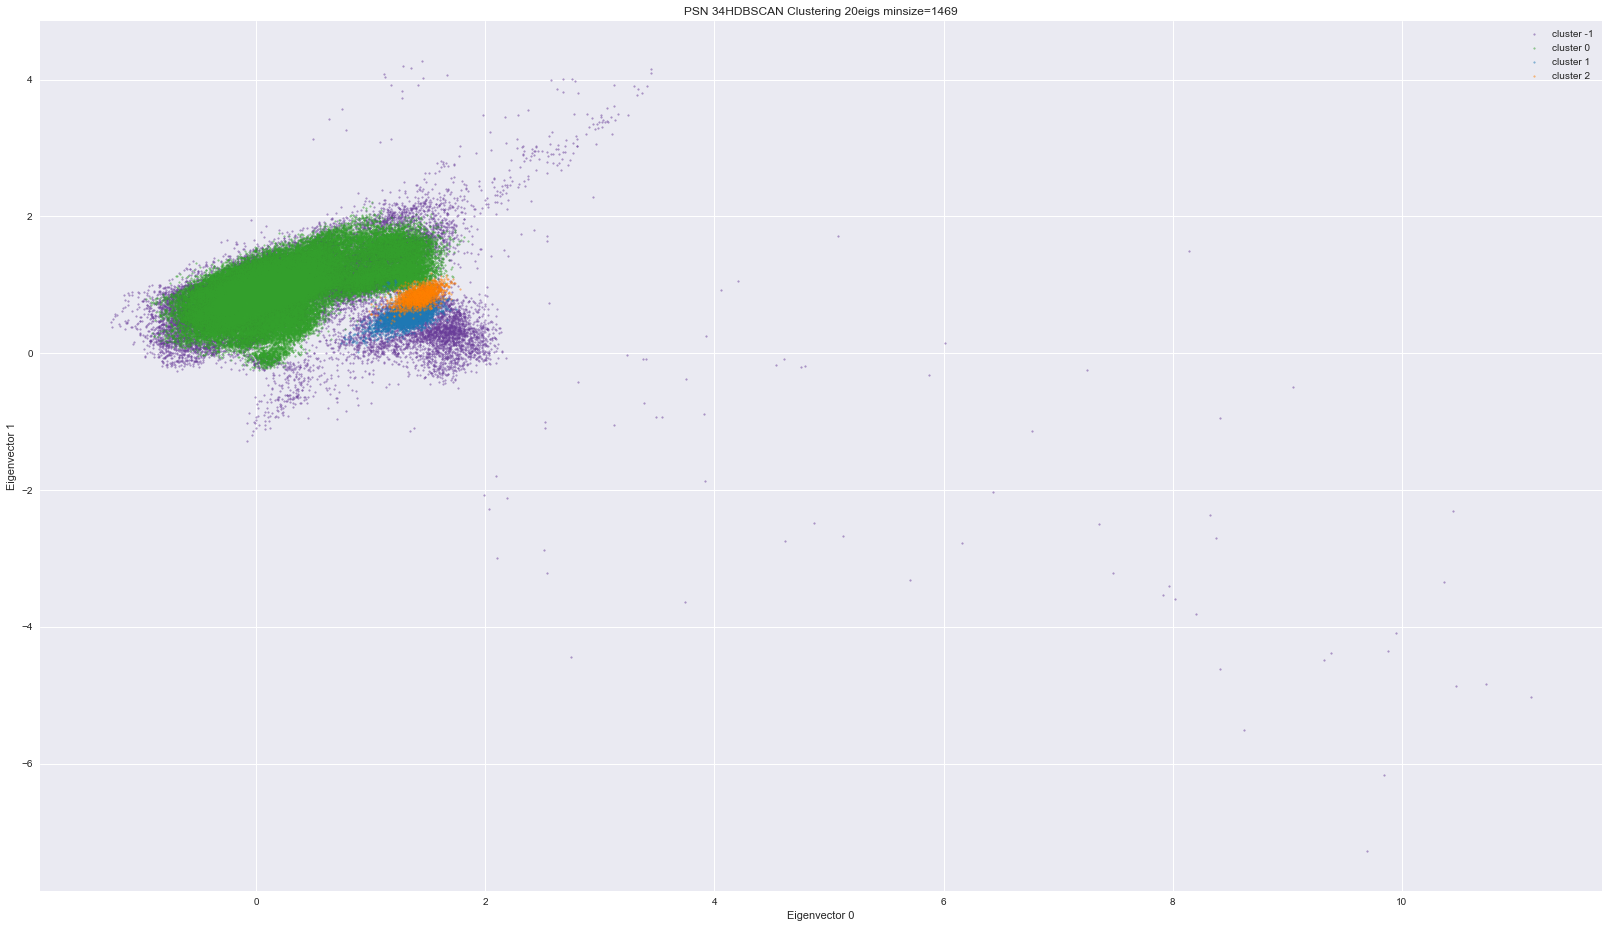

finished in total 102.2748498916626 seconds
started:  35
    clustering with min_cluster_size=1013.....(71208, 72) 71208
finished in 48.11375188827515 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


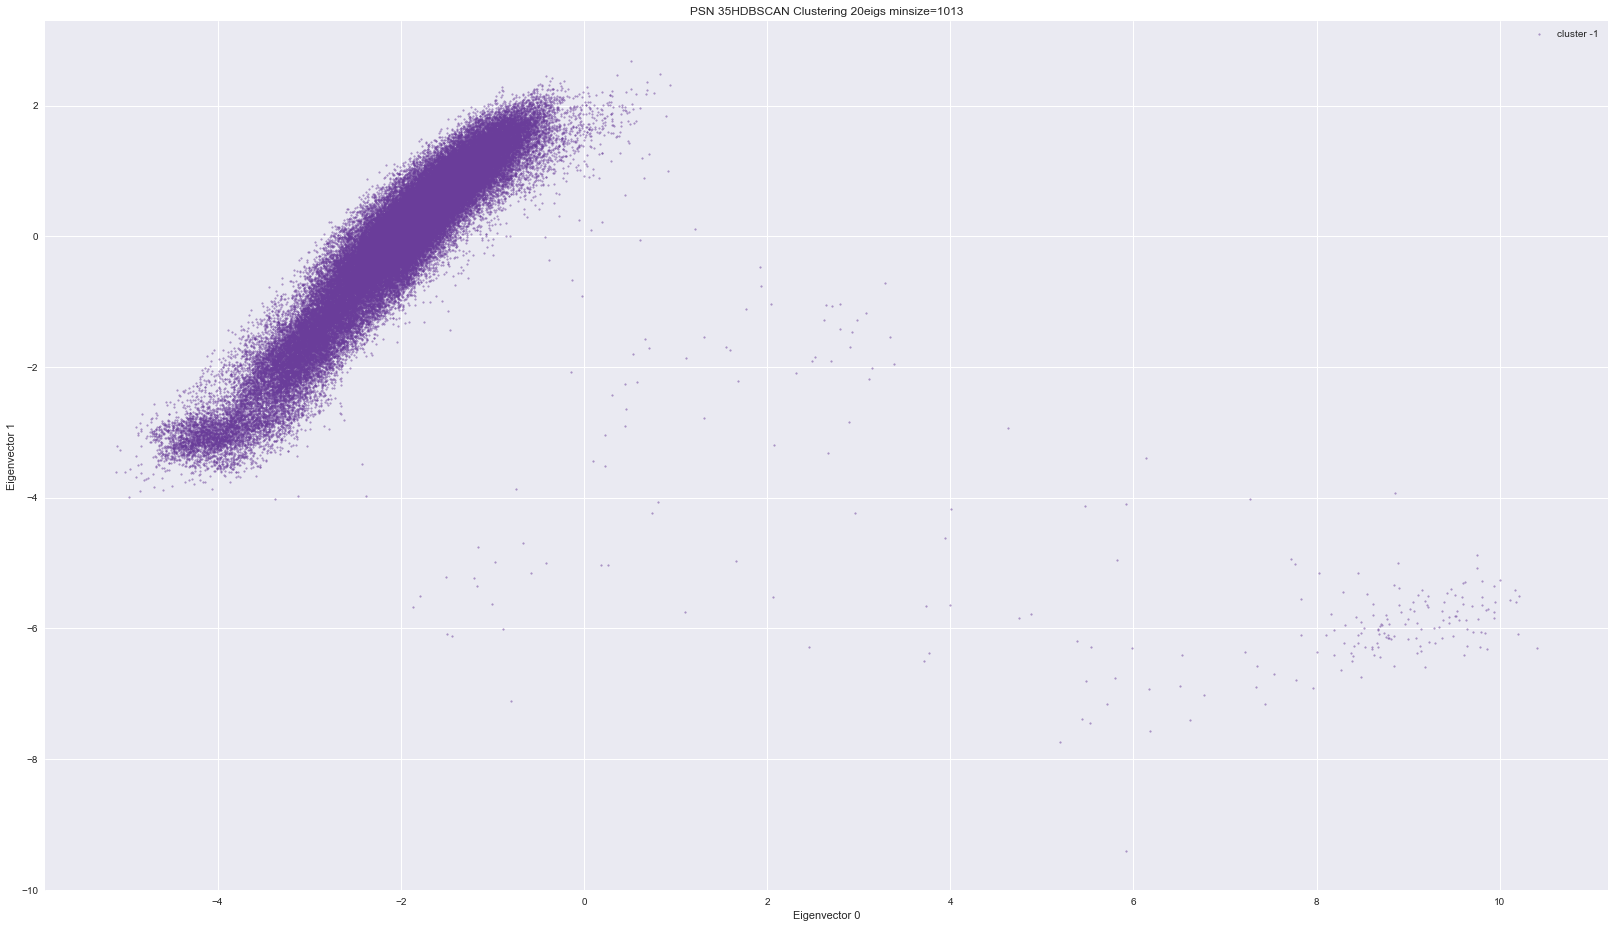

finished in total 49.5248327255249 seconds
started:  36
    clustering with min_cluster_size=1000.....(70287, 72) 70287
finished in 65.5257477760315 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


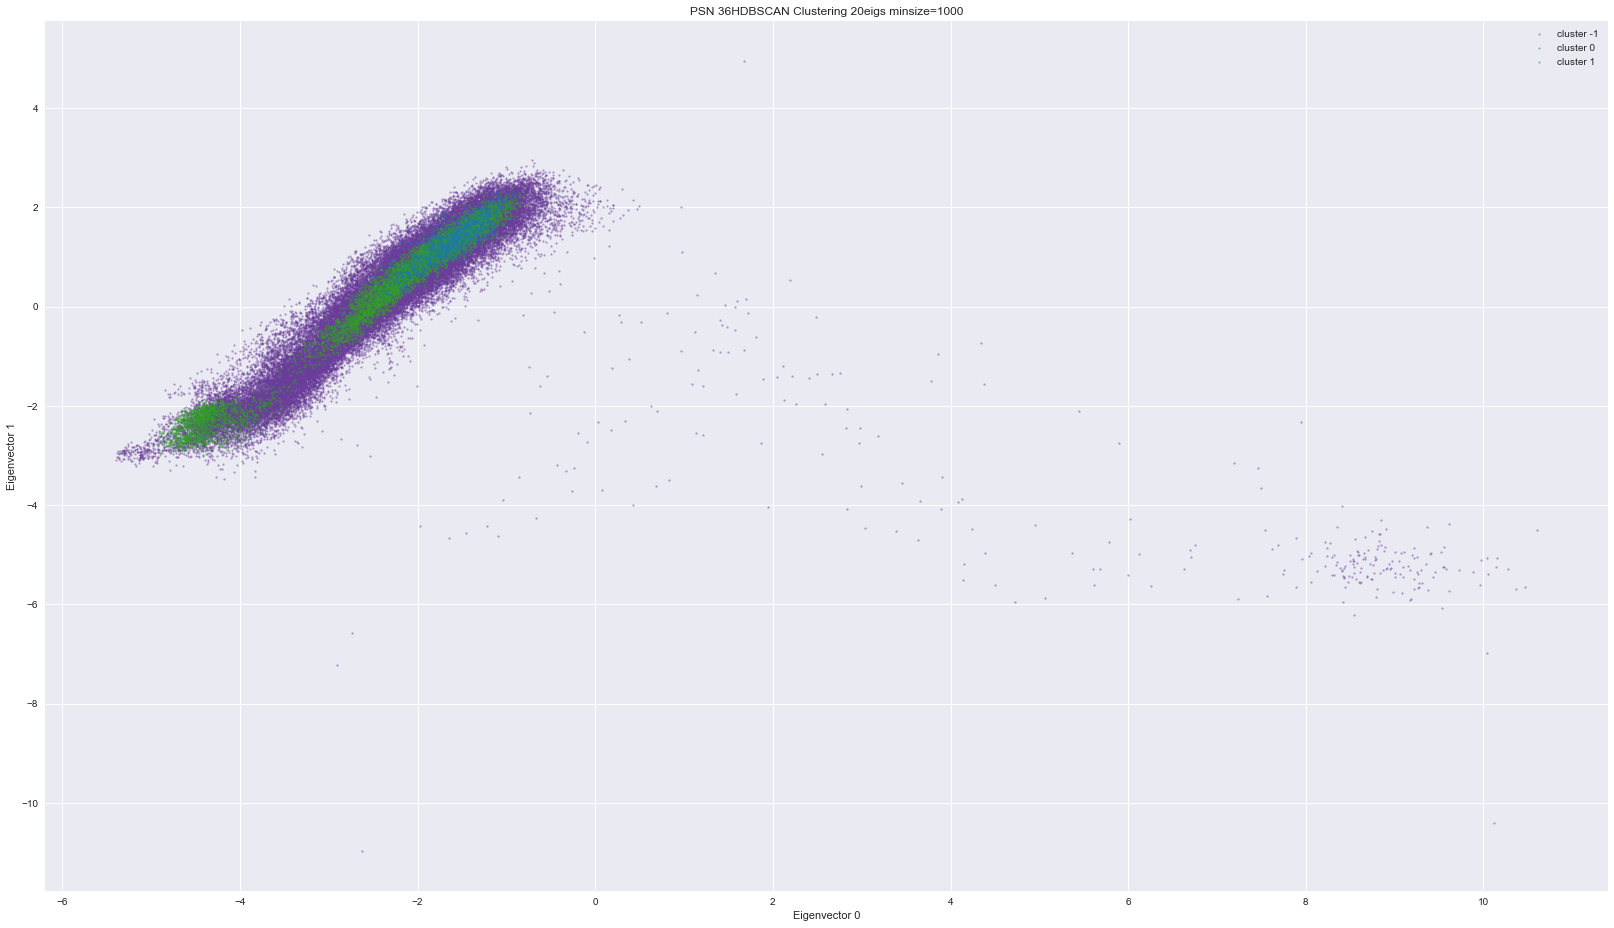

finished in total 66.96082973480225 seconds
started:  37
    clustering with min_cluster_size=934.....(65650, 72) 65650
finished in 44.12952423095703 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


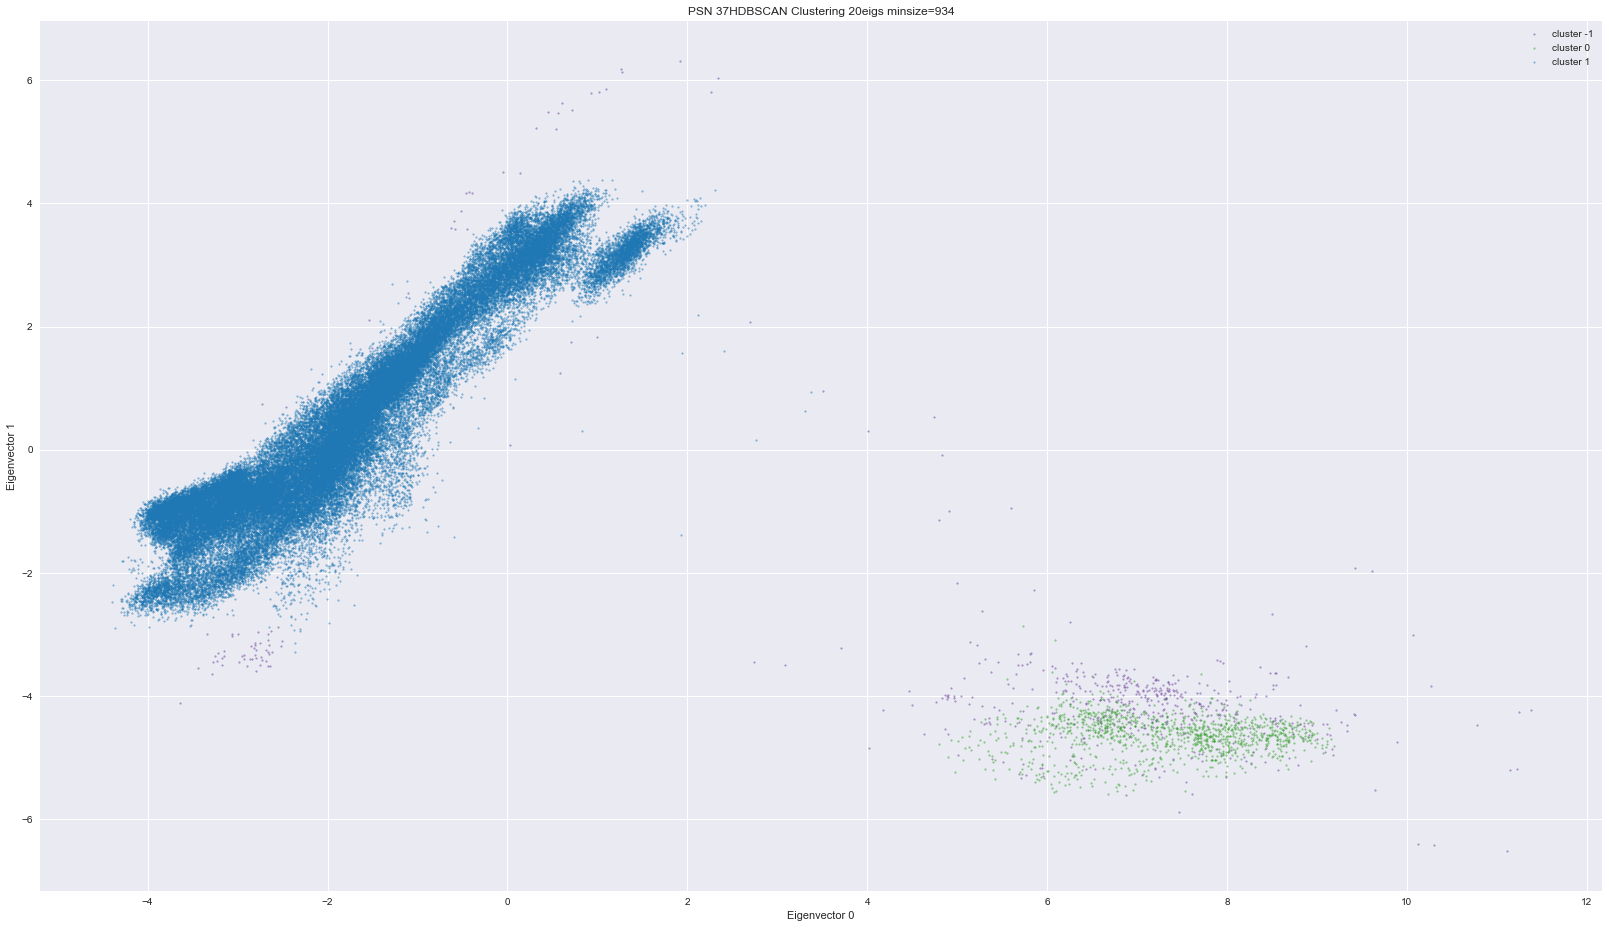

finished in total 45.503602743148804 seconds
started:  38
    clustering with min_cluster_size=428.....(30025, 72) 30025
finished in 13.441768646240234 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


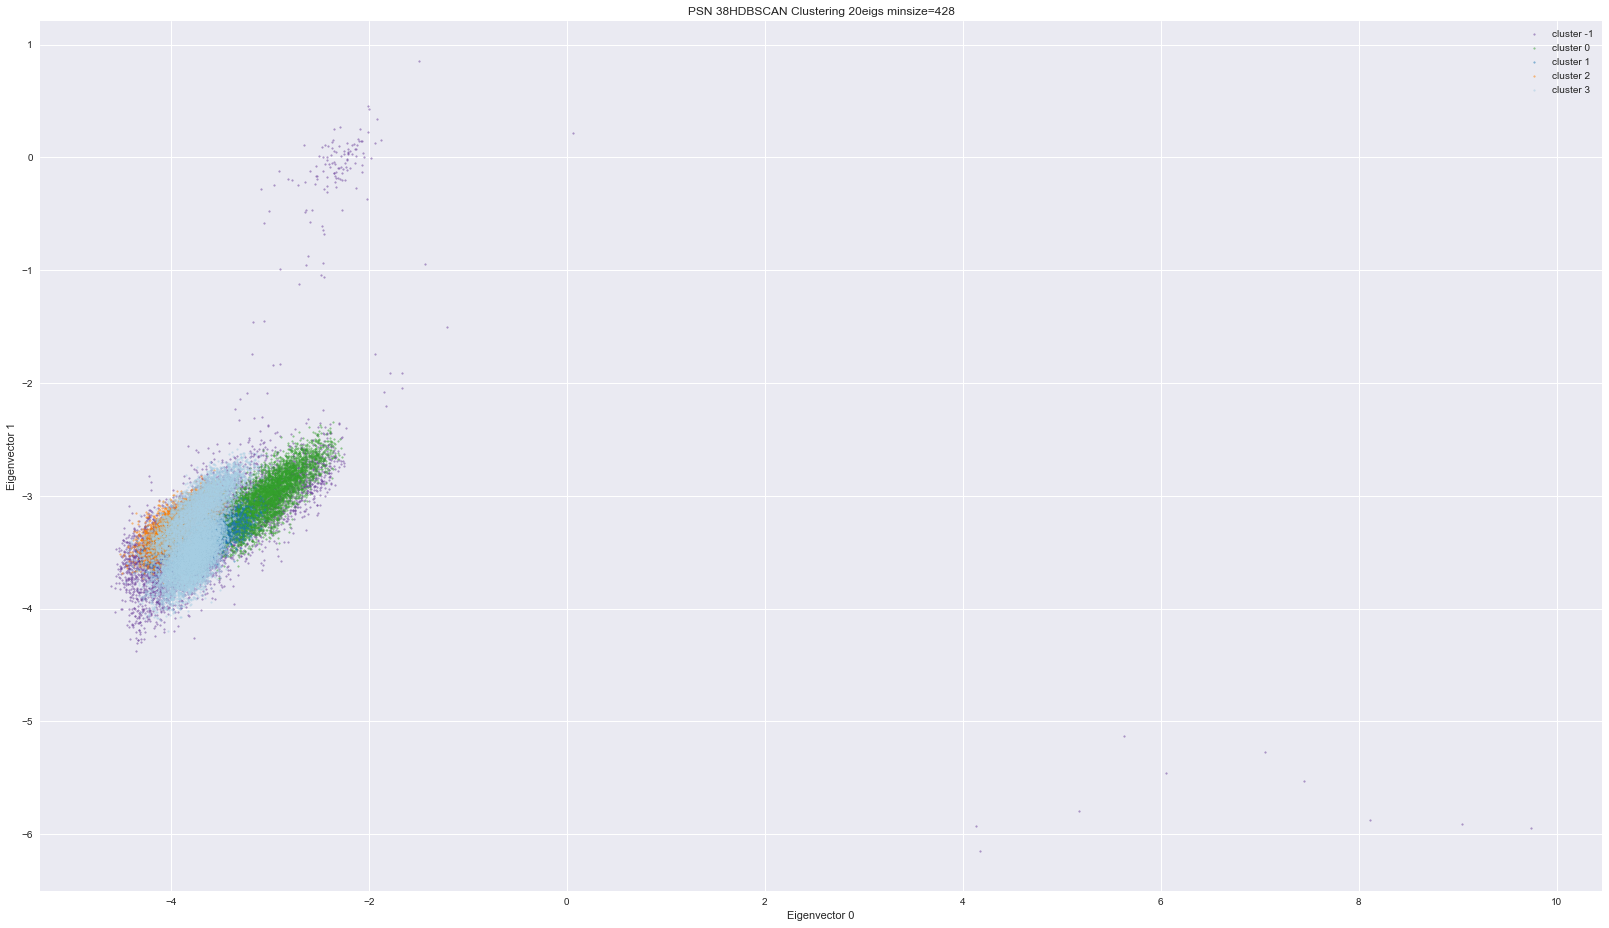

finished in total 14.373822212219238 seconds
started:  39
    clustering with min_cluster_size=318.....(22333, 72) 22333
finished in 6.187353849411011 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


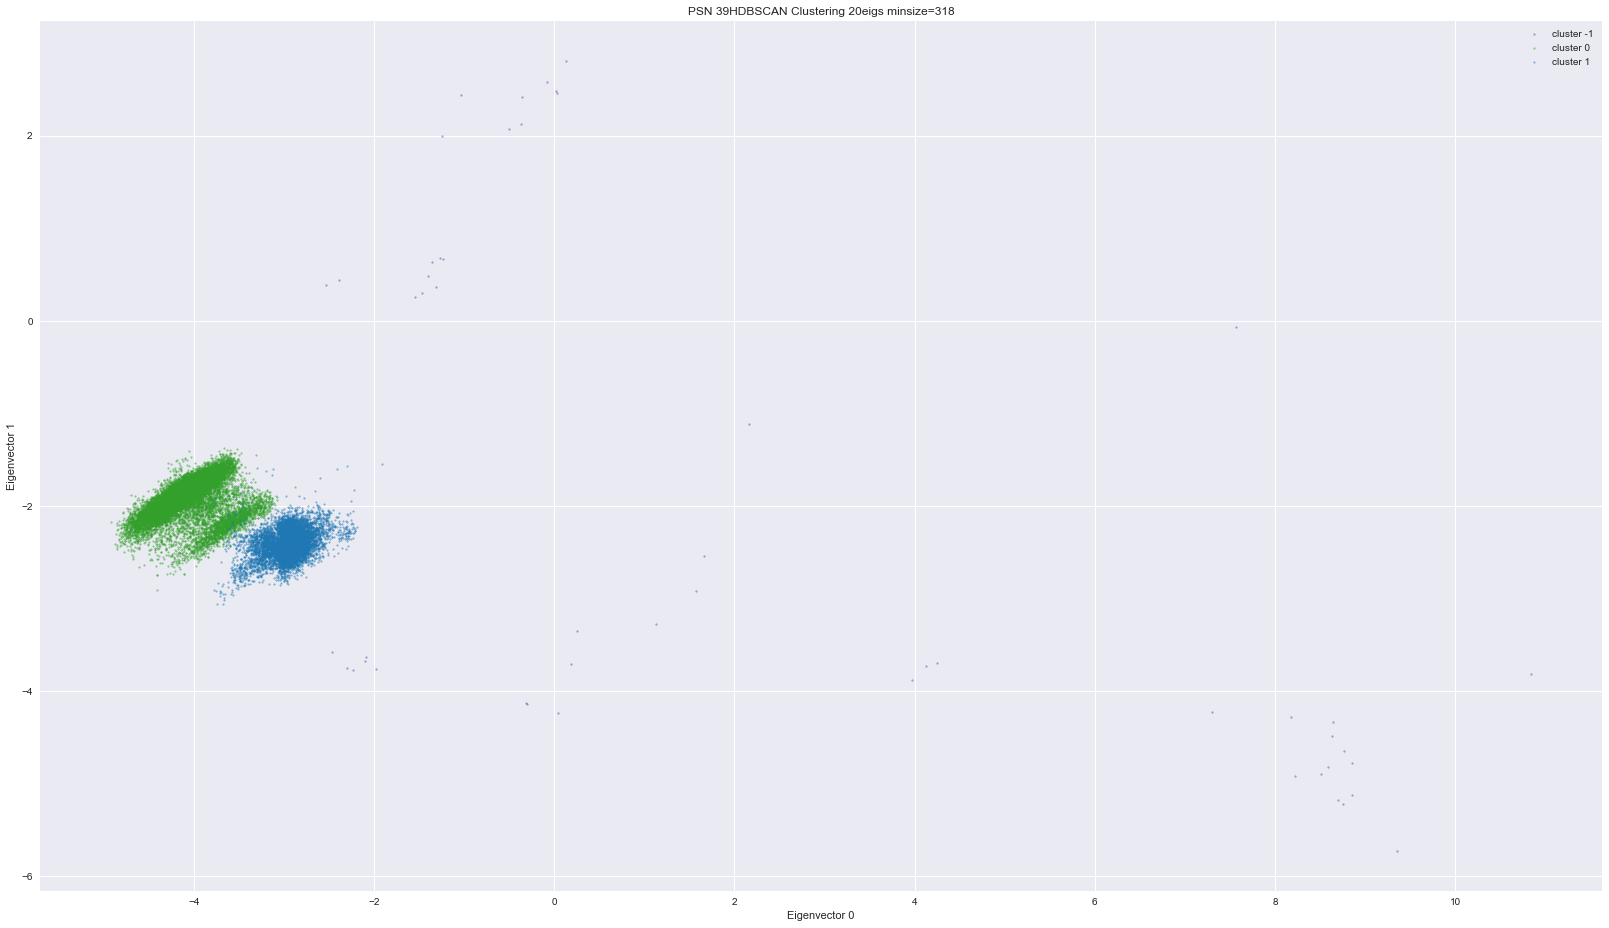

finished in total 6.967398405075073 seconds
started:  40
    clustering with min_cluster_size=200.....(14024, 72) 14024
finished in 4.575261831283569 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


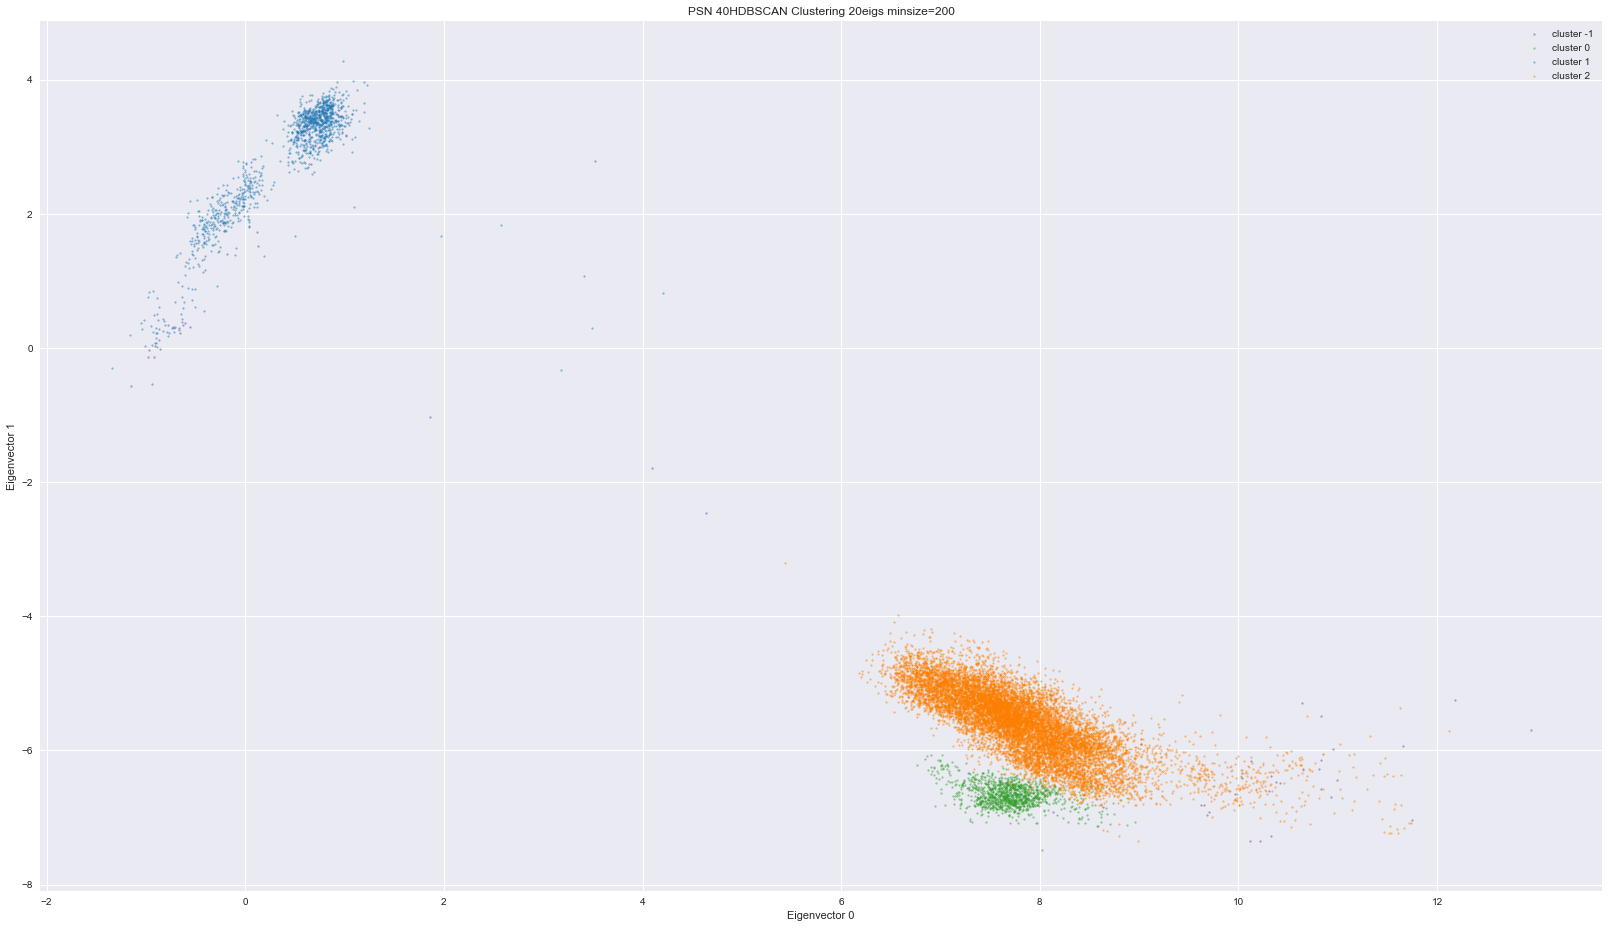

finished in total 5.294302940368652 seconds
started:  41
    clustering with min_cluster_size=221.....(15484, 72) 15484
finished in 3.935225009918213 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


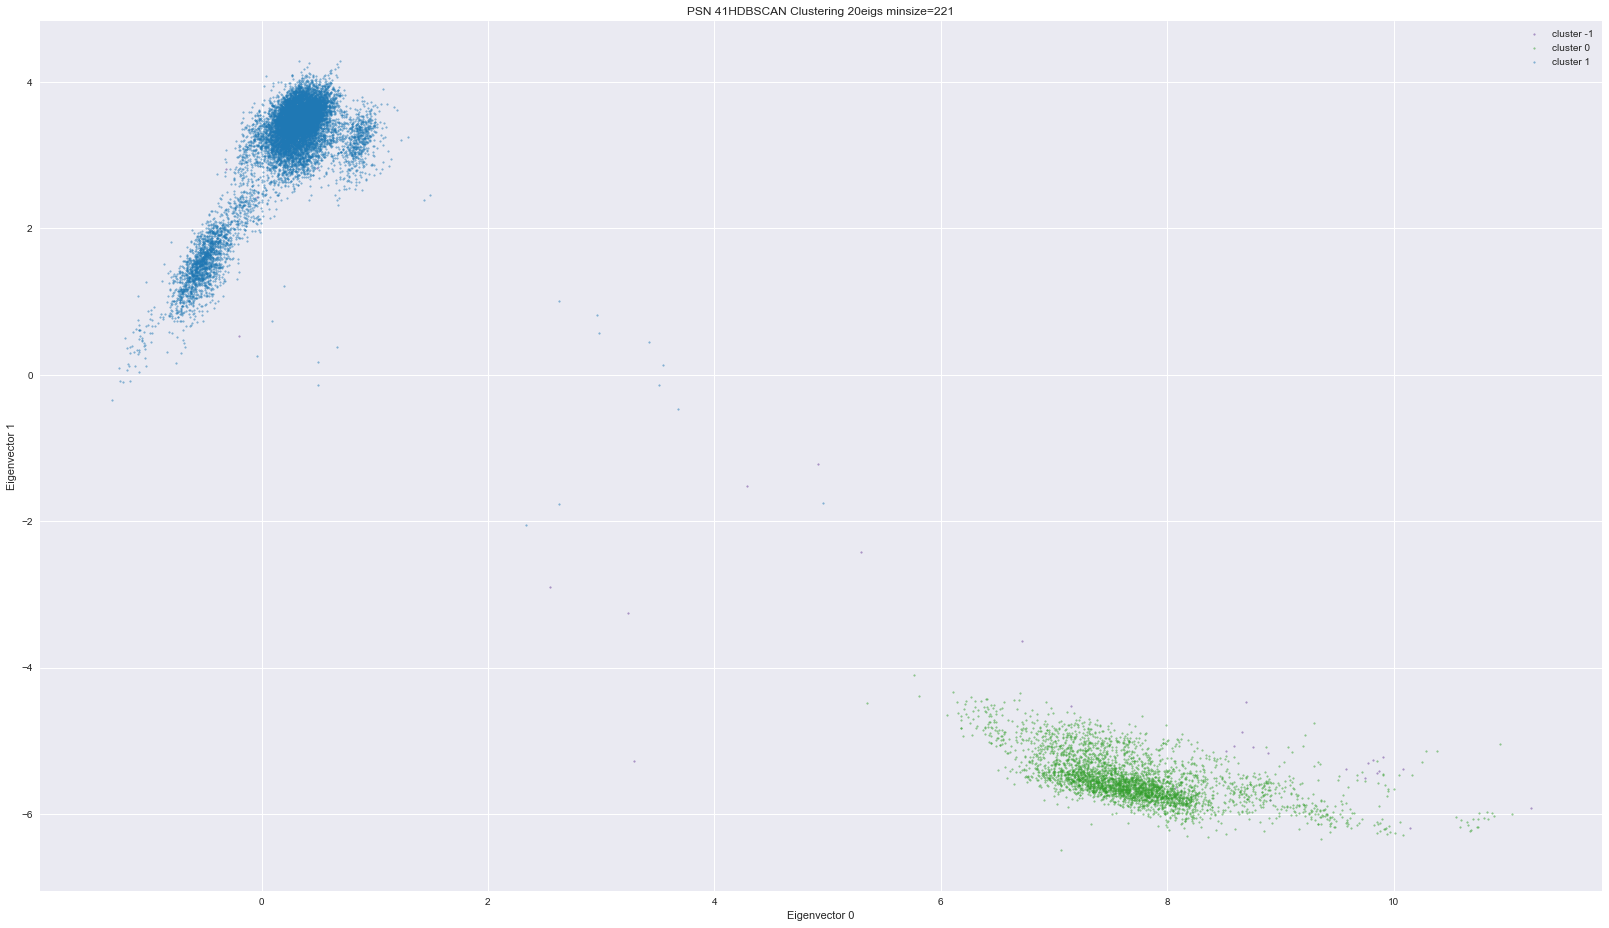

finished in total 4.649266004562378 seconds
started:  42
    clustering with min_cluster_size=1358.....(95461, 72) 95461
finished in 102.96388912200928 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


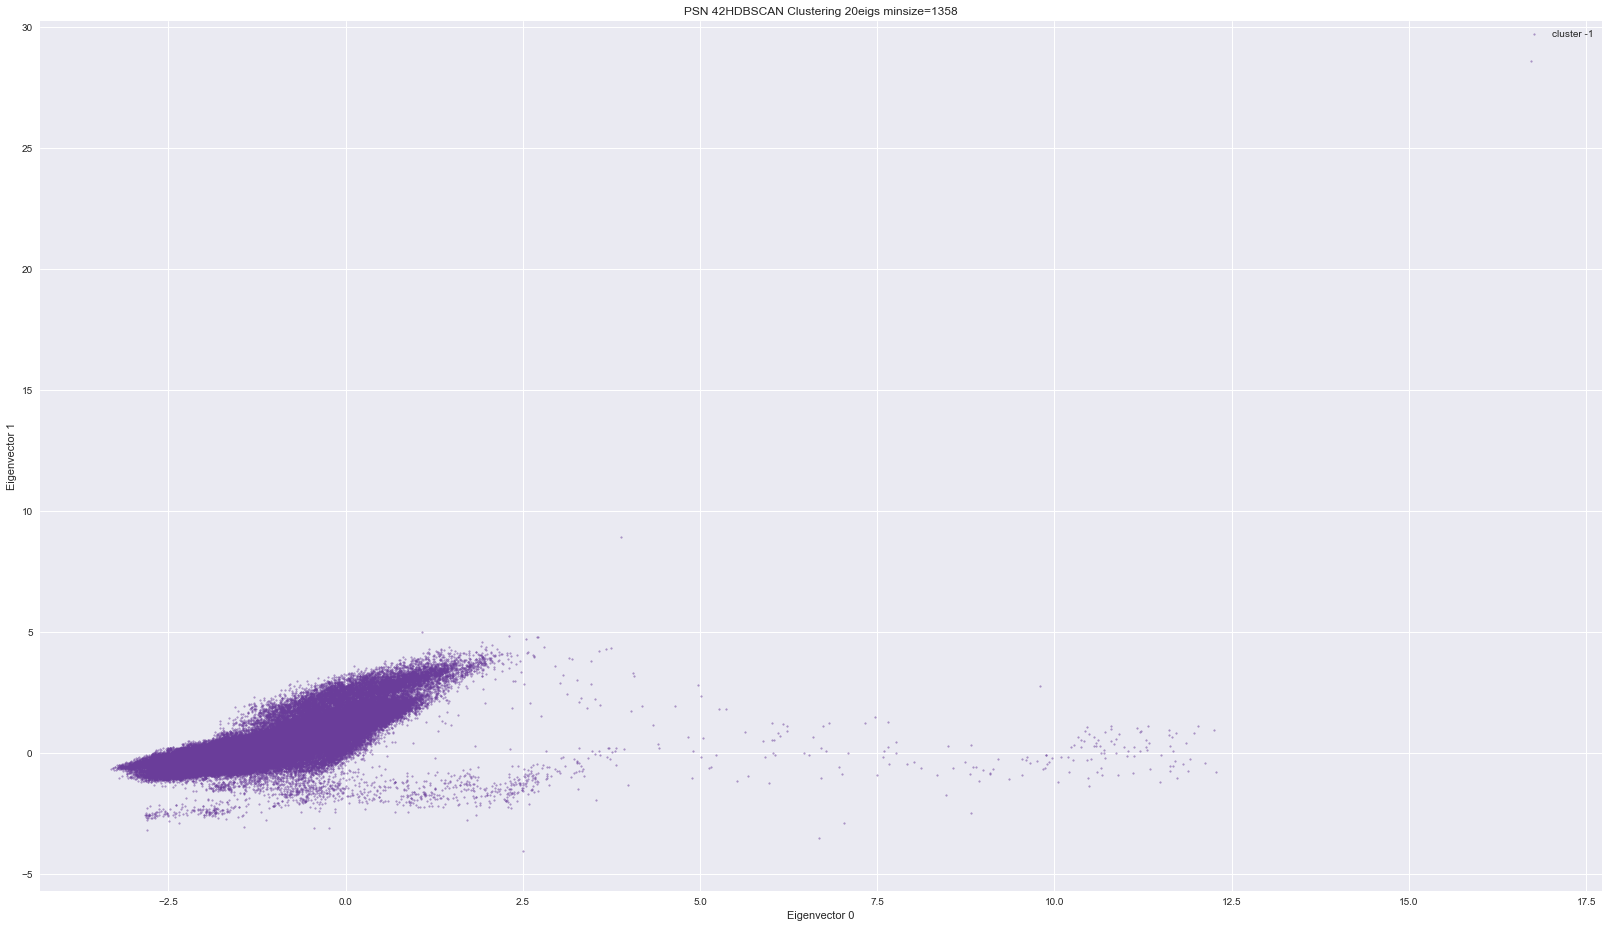

finished in total 104.74799108505249 seconds
started:  45
    clustering with min_cluster_size=694.....(48741, 72) 48741
finished in 23.276331186294556 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


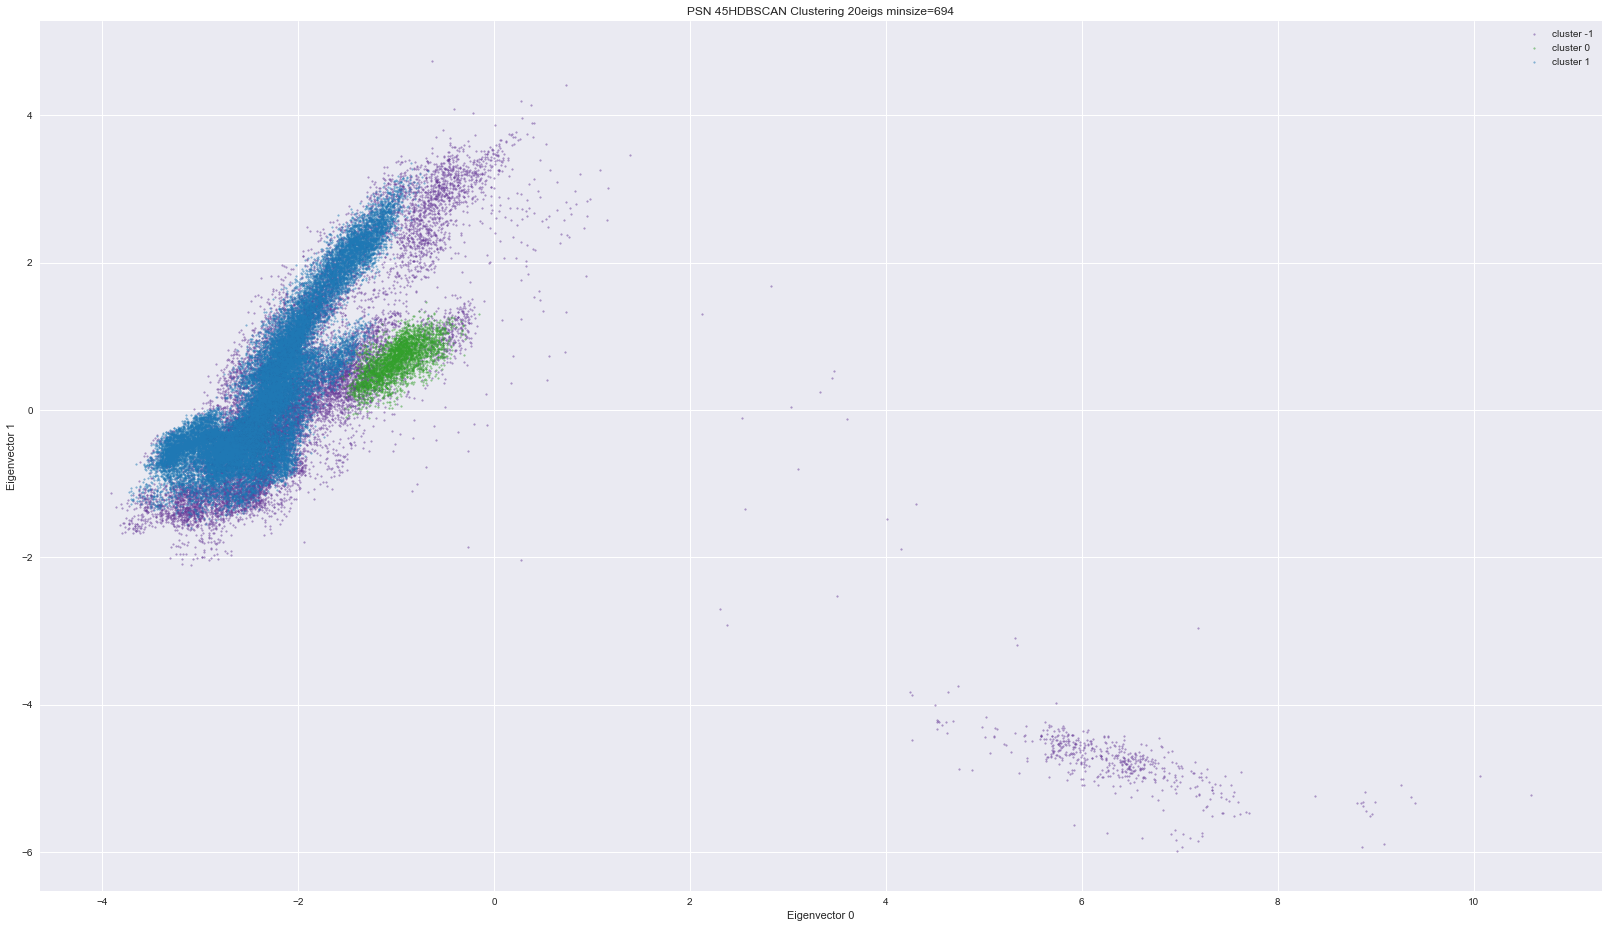

finished in total 24.451398372650146 seconds
started:  46
    clustering with min_cluster_size=108.....(7592, 72) 7592
finished in 0.8710498809814453 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


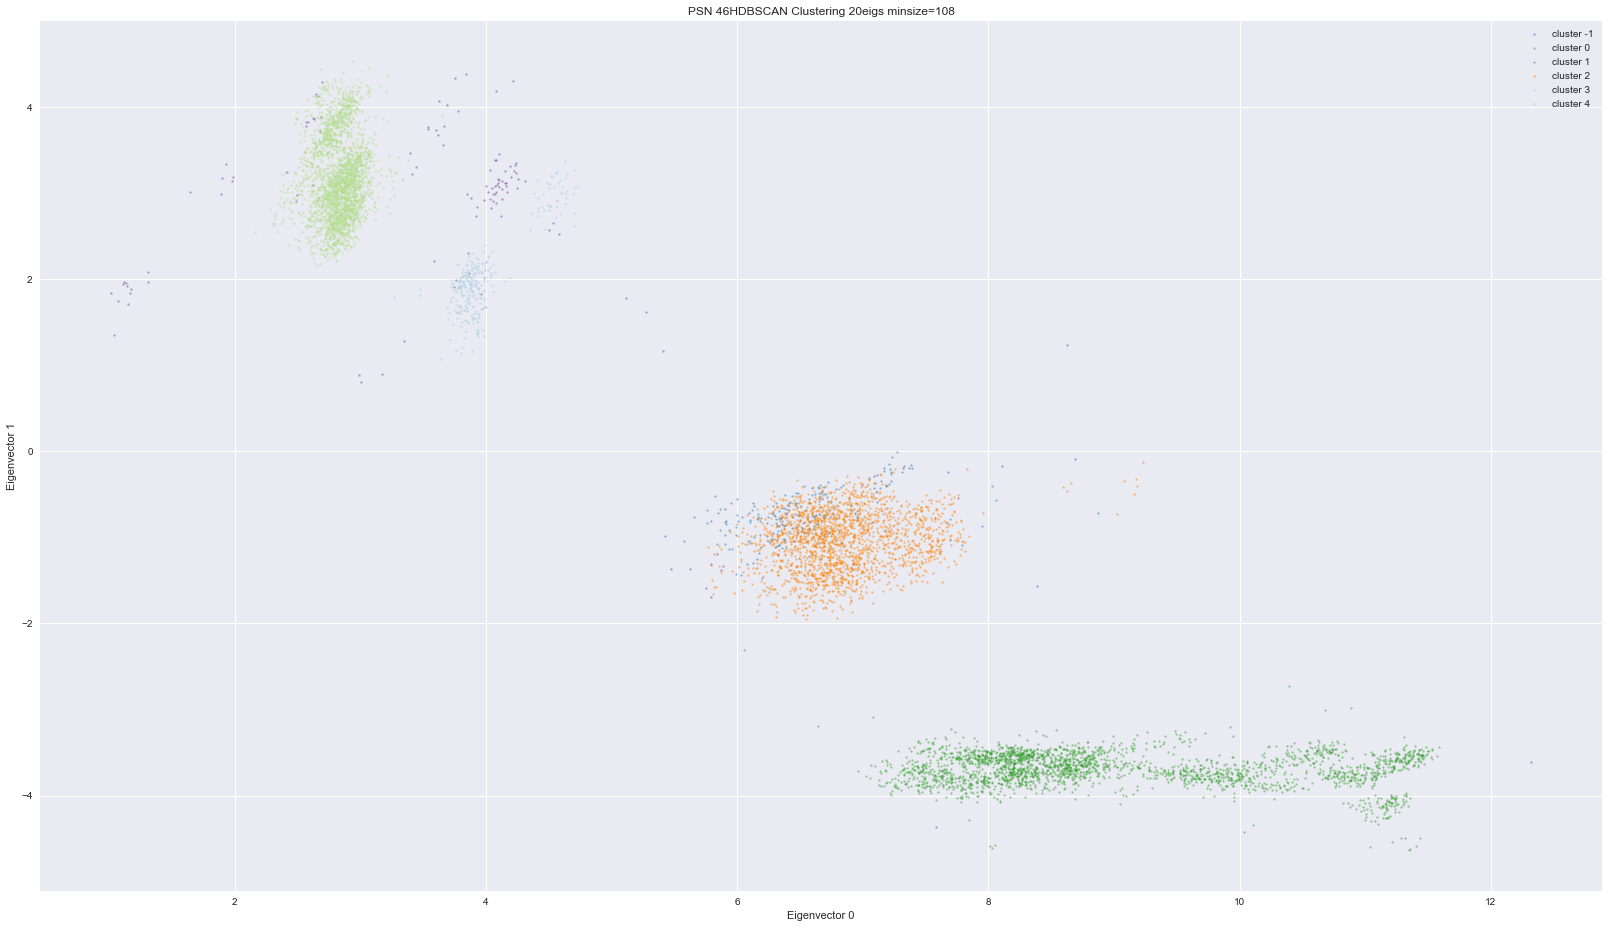

finished in total 1.5290875434875488 seconds
started:  47
    clustering with min_cluster_size=156.....(10941, 72) 10941
finished in 1.8581061363220215 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


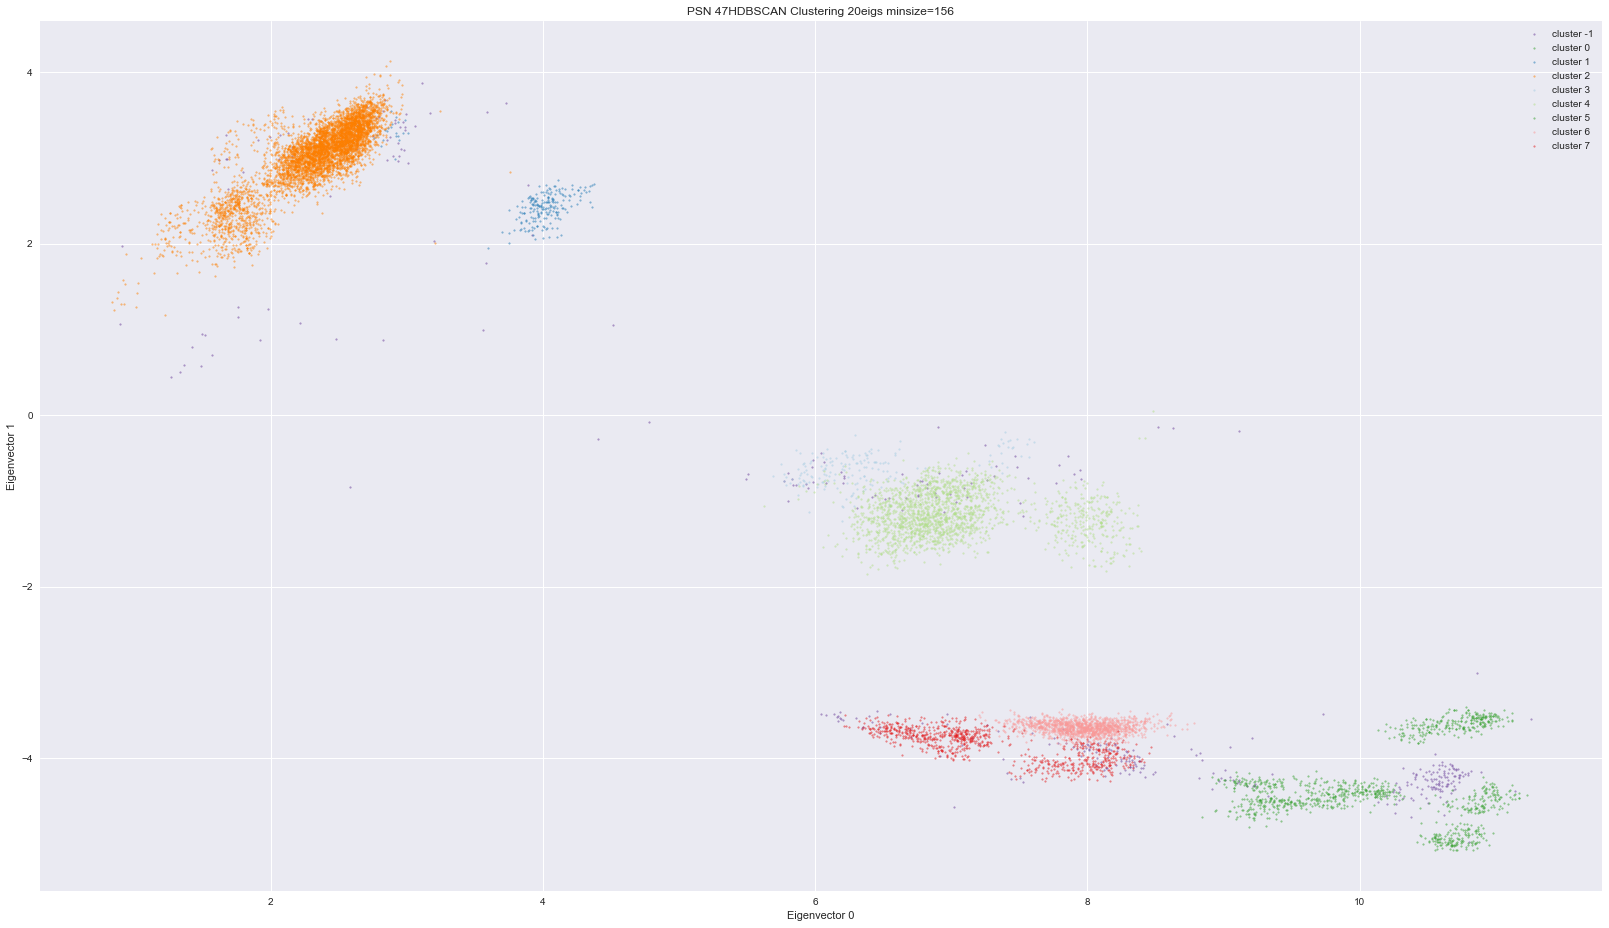

finished in total 2.6041488647460938 seconds
started:  48
    clustering with min_cluster_size=1323.....(92989, 72) 92989
finished in 59.742417097091675 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


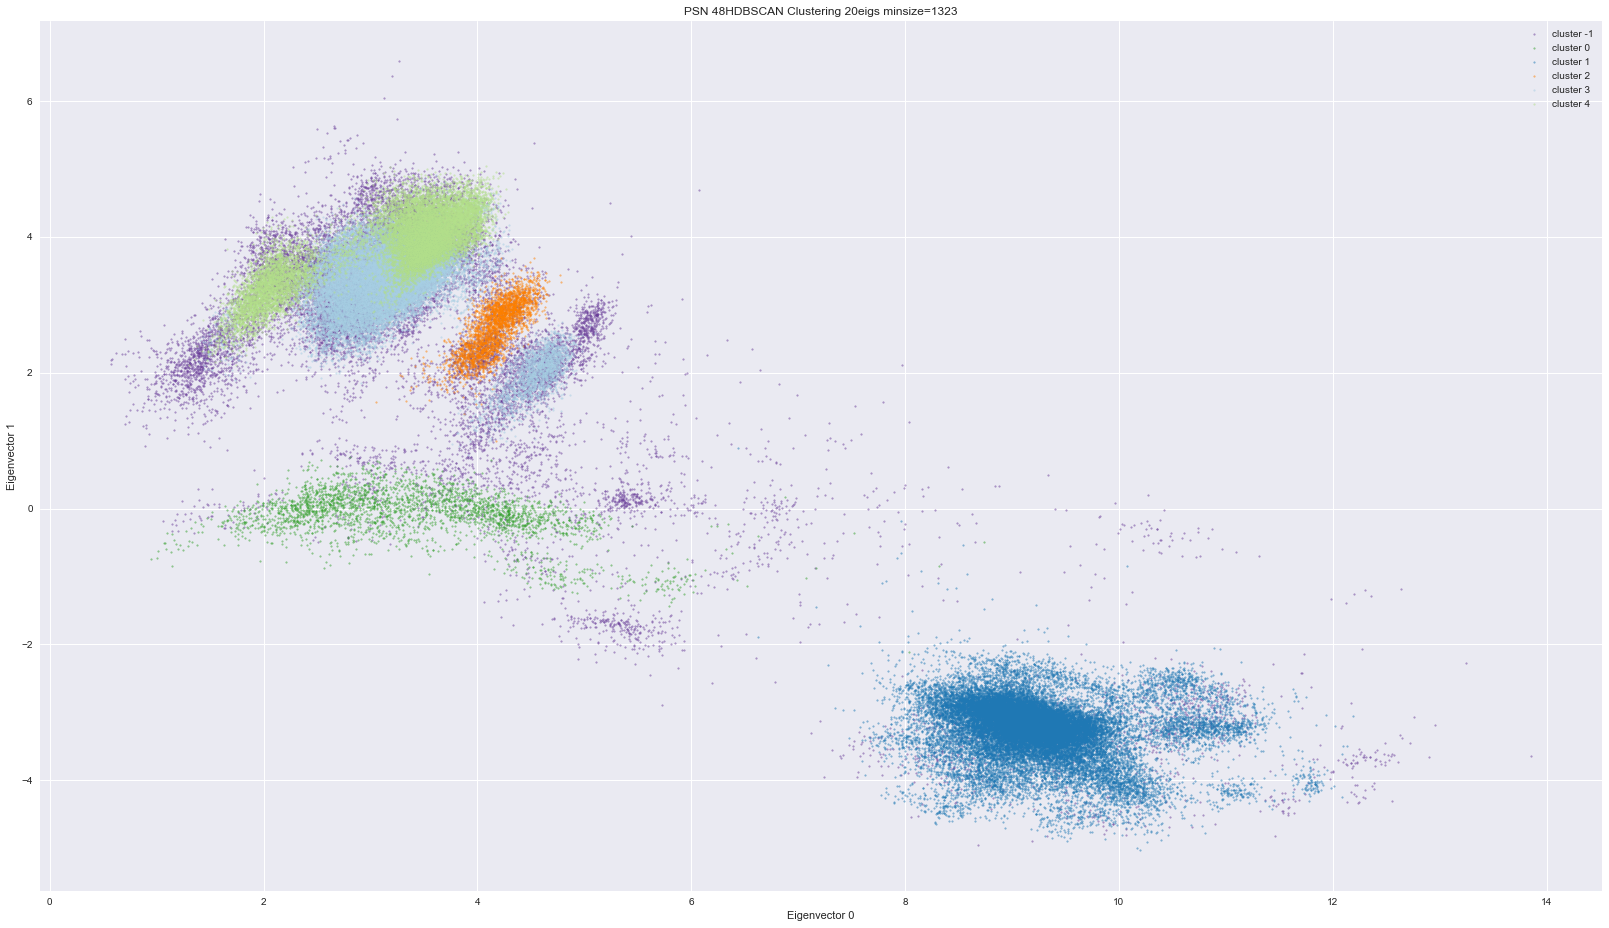

finished in total 61.5835223197937 seconds
started:  49
    clustering with min_cluster_size=1274.....(89536, 72) 89536
finished in 69.6979866027832 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


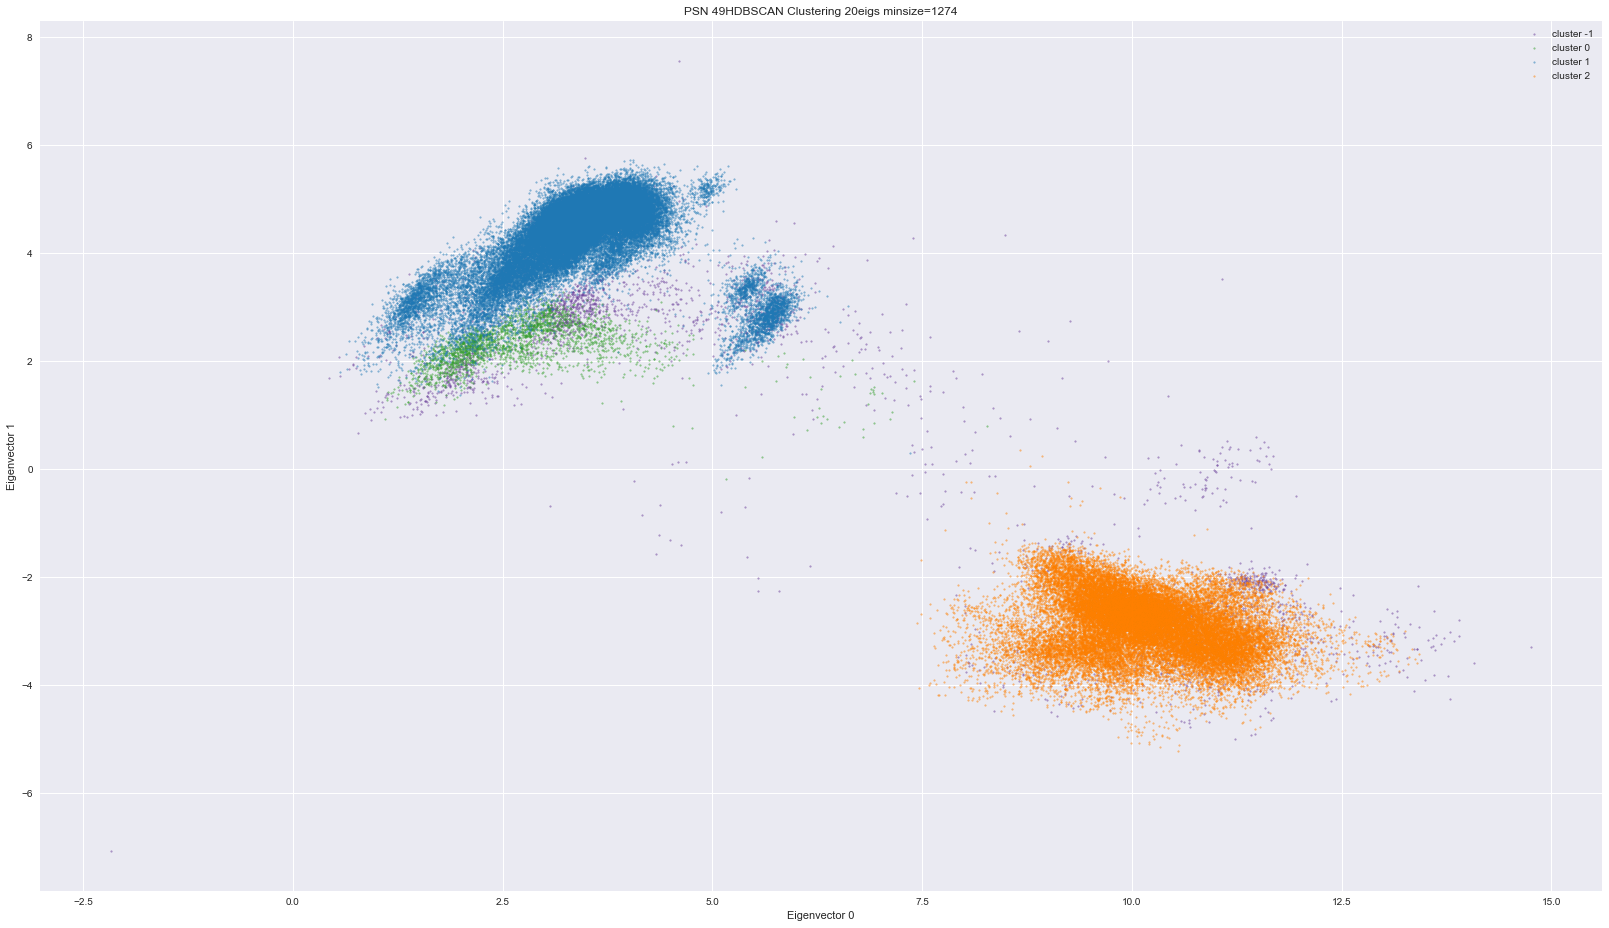

finished in total 71.45408701896667 seconds
started:  50
    clustering with min_cluster_size=36.....(2516, 72) 2516
finished in 0.23101305961608887 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


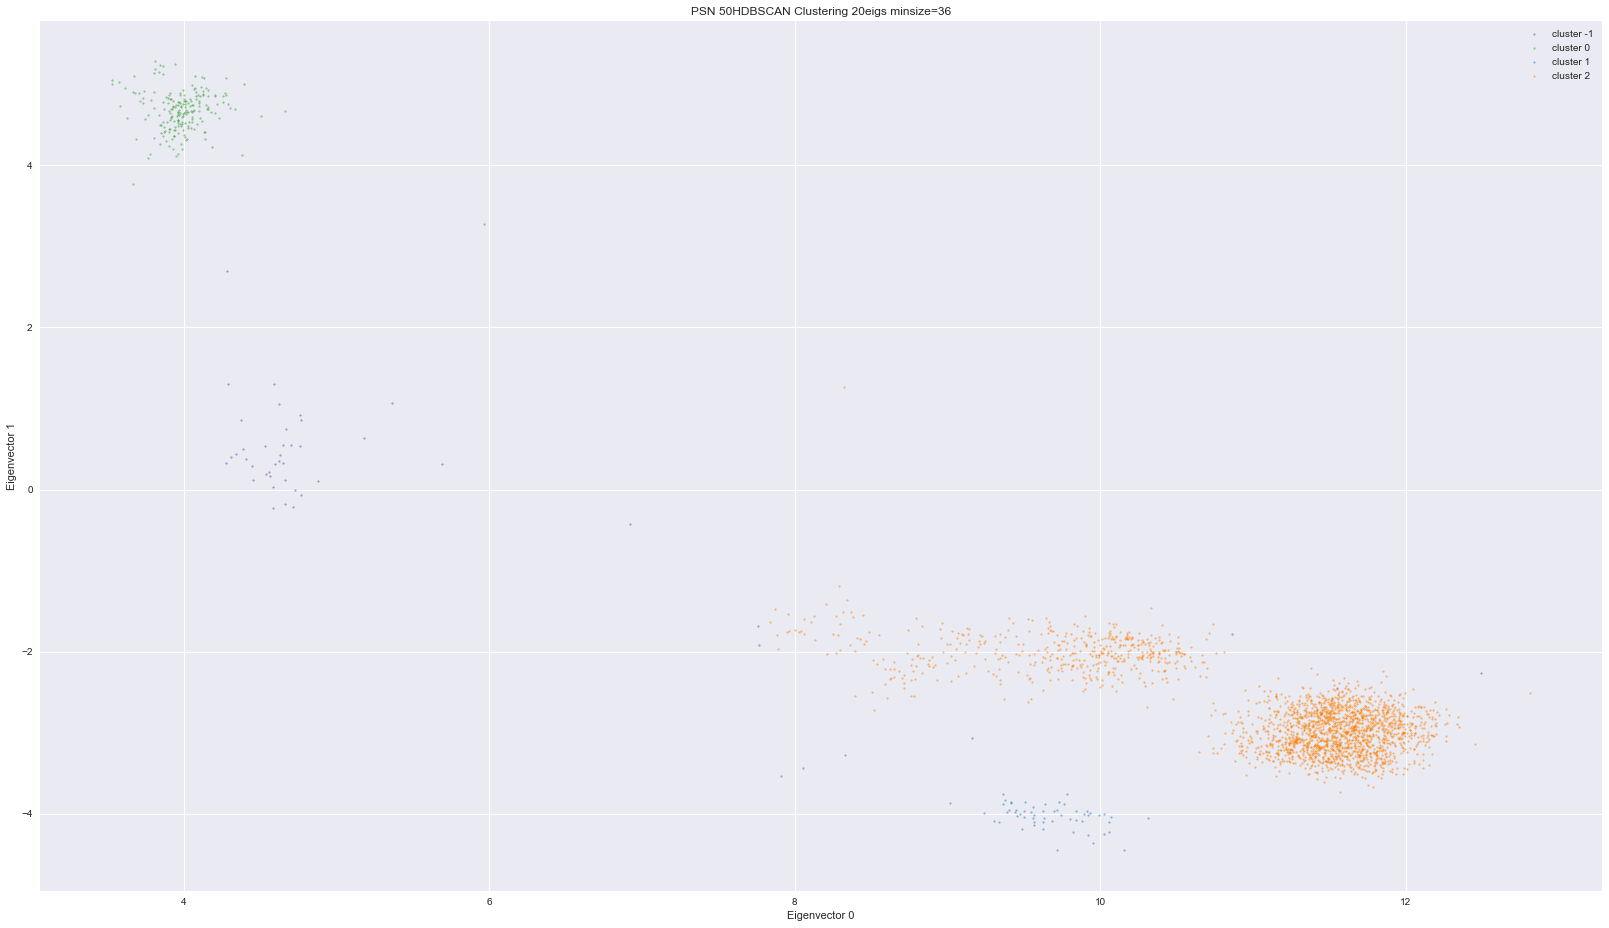

finished in total 0.8000457286834717 seconds
started:  51
    clustering with min_cluster_size=78.....(5463, 72) 5463
finished in 0.5990340709686279 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


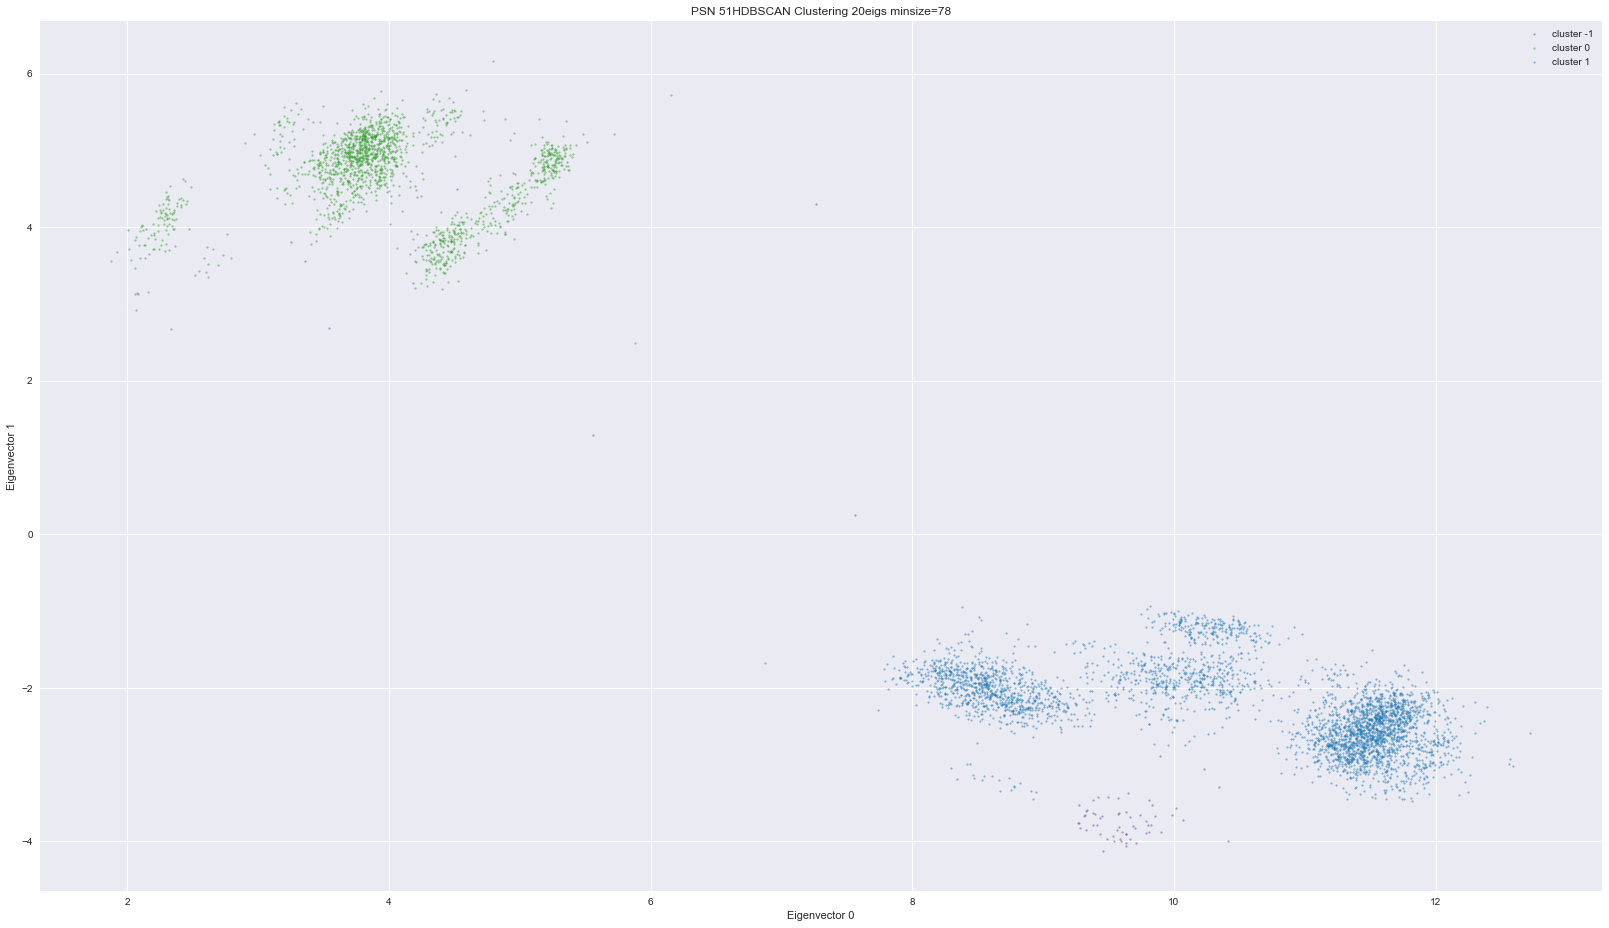

finished in total 1.187067985534668 seconds
started:  53
    clustering with min_cluster_size=523.....(36714, 72) 36714
finished in 16.725956678390503 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


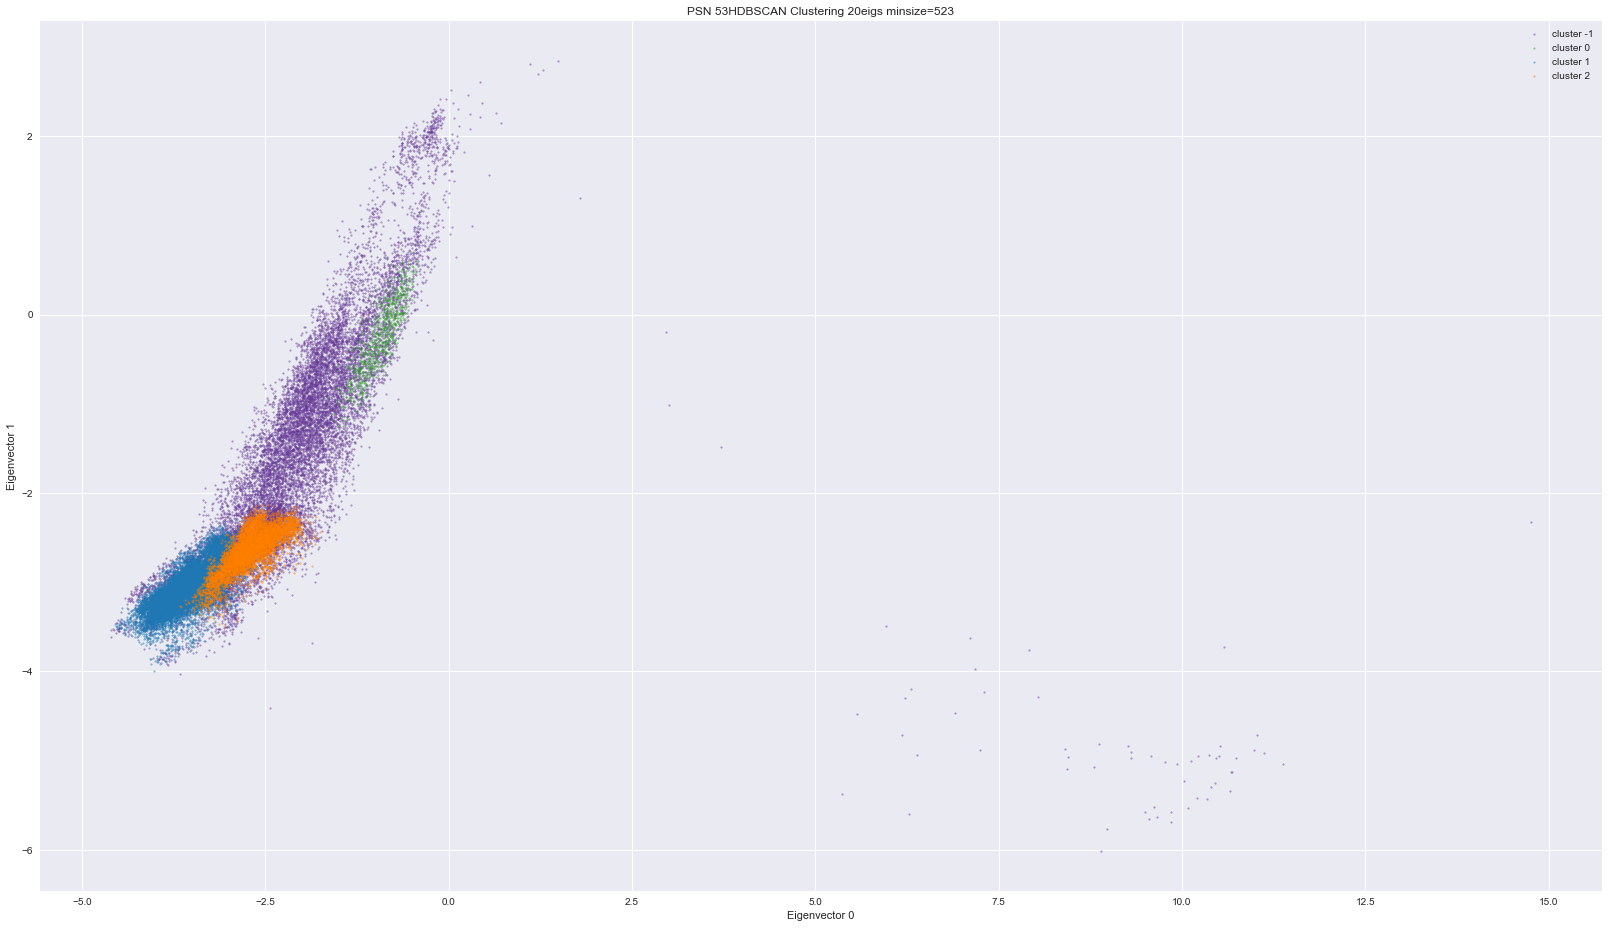

finished in total 17.73501443862915 seconds
started:  55
    clustering with min_cluster_size=1101.....(77340, 72) 77340
finished in 45.796619176864624 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


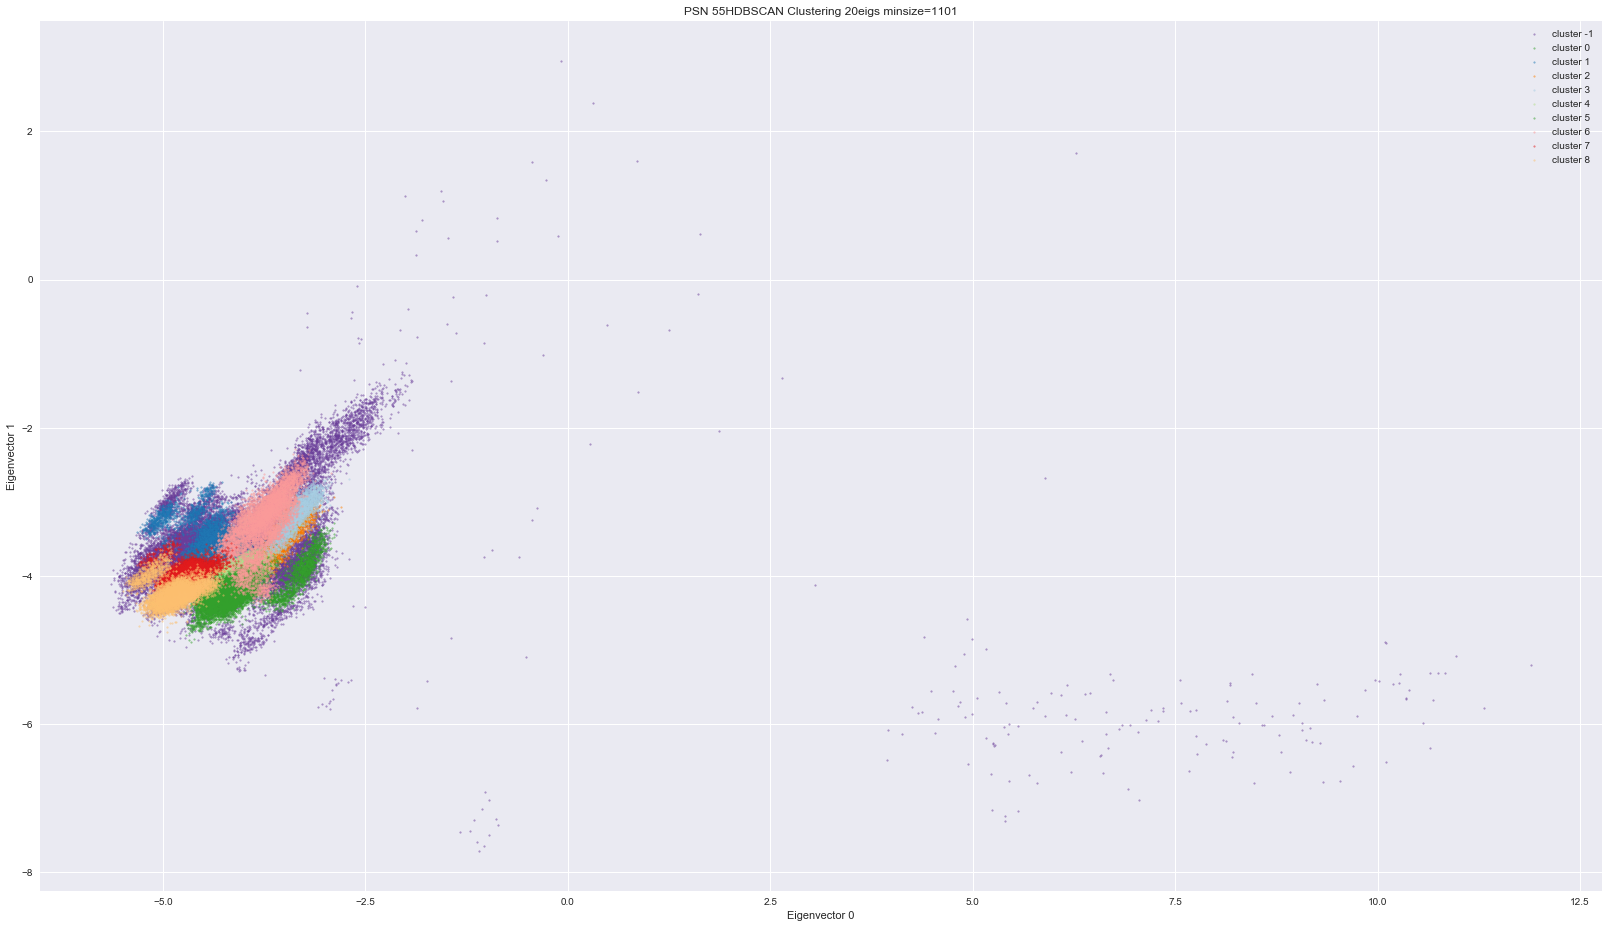

finished in total 47.43271279335022 seconds
started:  56
    clustering with min_cluster_size=1147.....(80596, 72) 80596
finished in 62.72558784484863 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


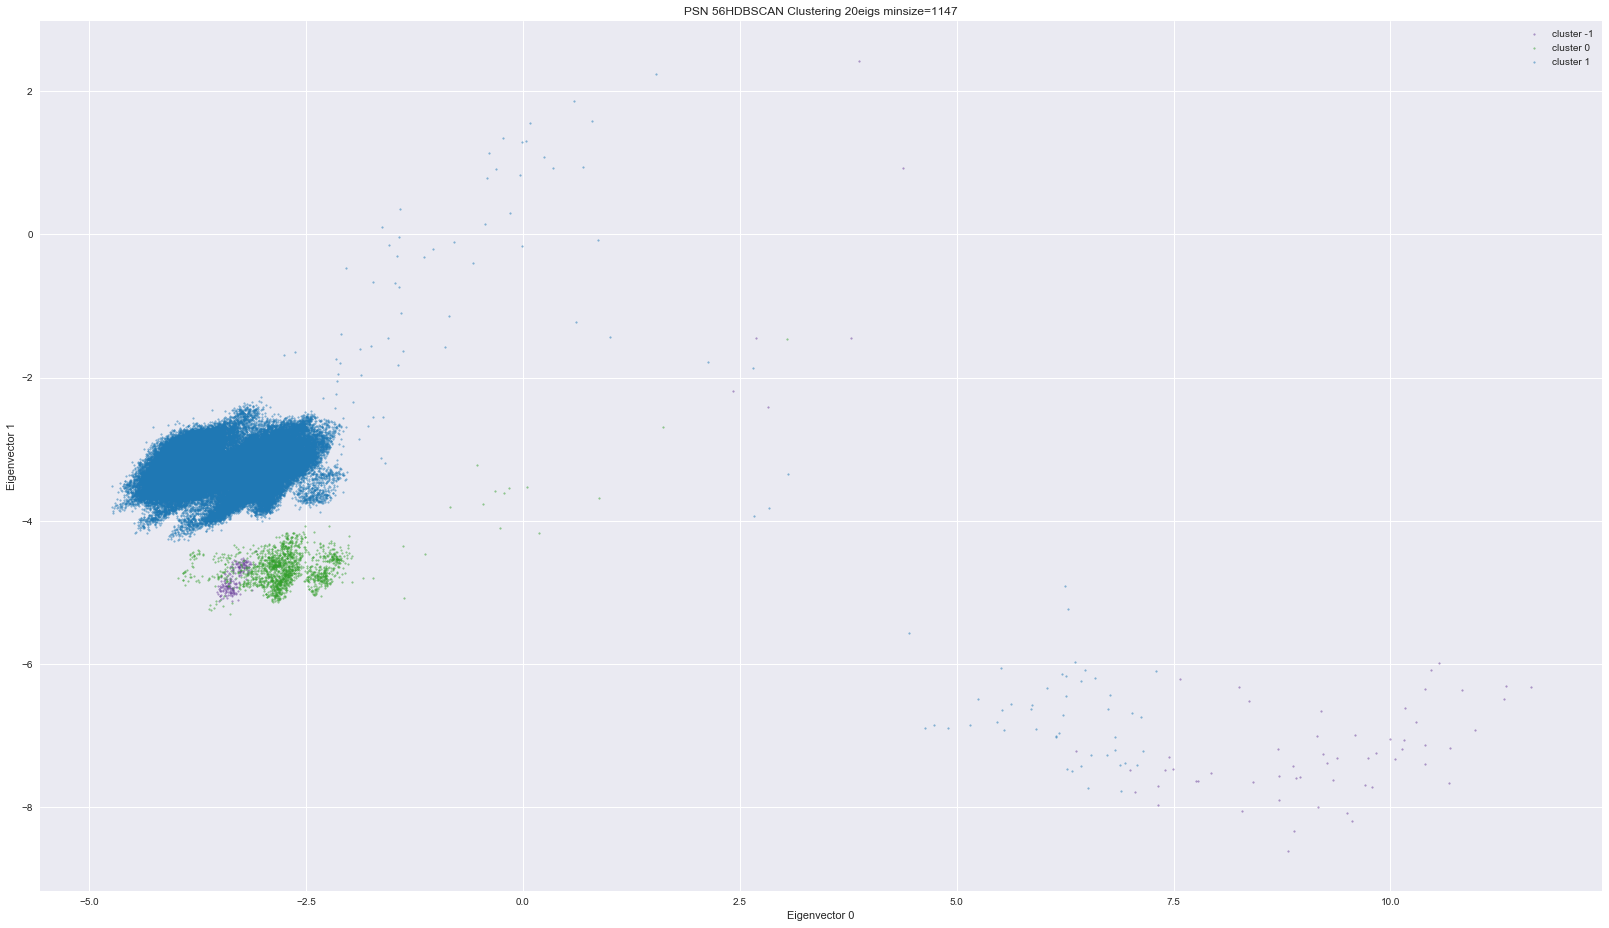

finished in total 64.27367639541626 seconds
started:  57
    clustering with min_cluster_size=935.....(65672, 72) 65672
finished in 51.048919916152954 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


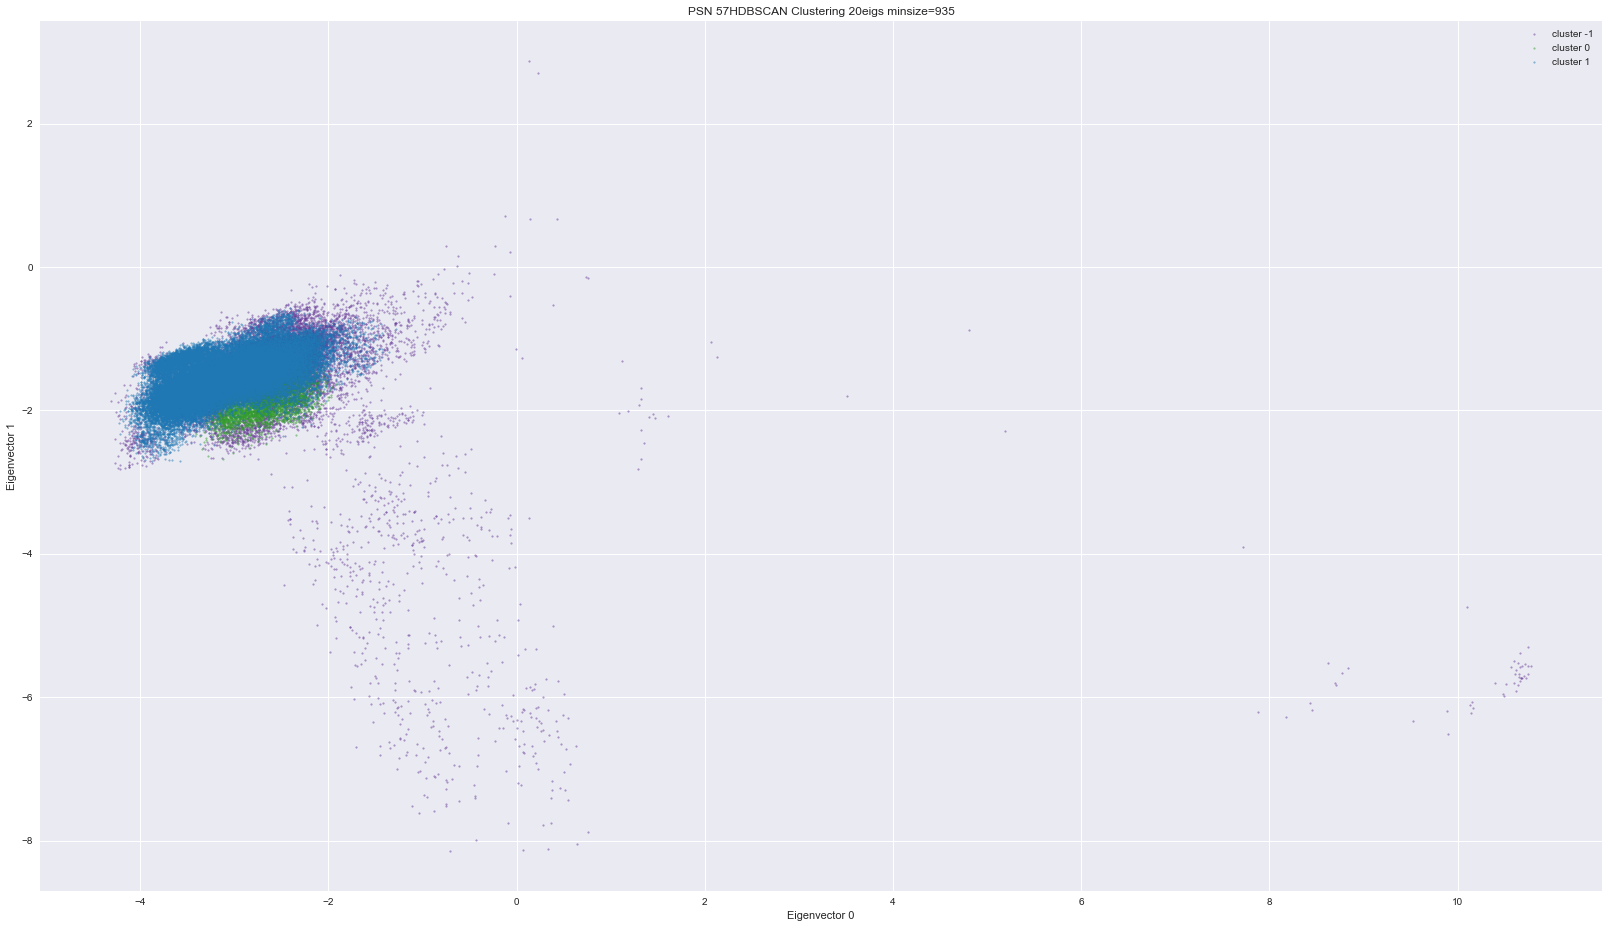

finished in total 52.3629949092865 seconds
started:  58
    clustering with min_cluster_size=838.....(58907, 72) 58907
finished in 25.16343903541565 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


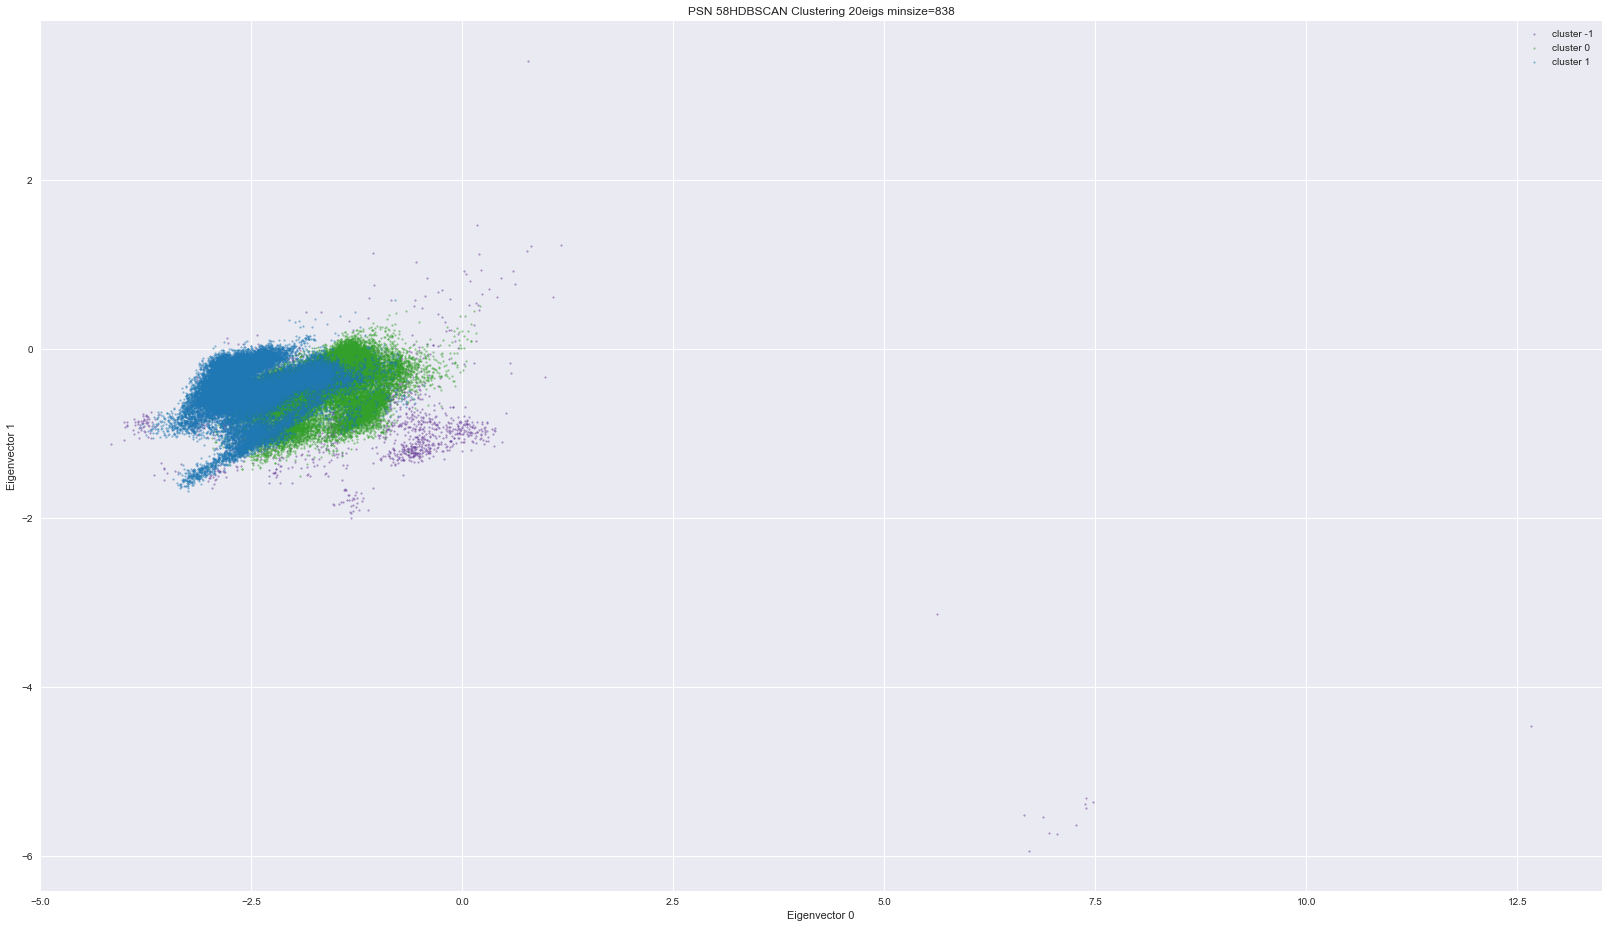

finished in total 26.46251344680786 seconds
started:  59
    clustering with min_cluster_size=946.....(66452, 72) 66452
finished in 47.28070425987244 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


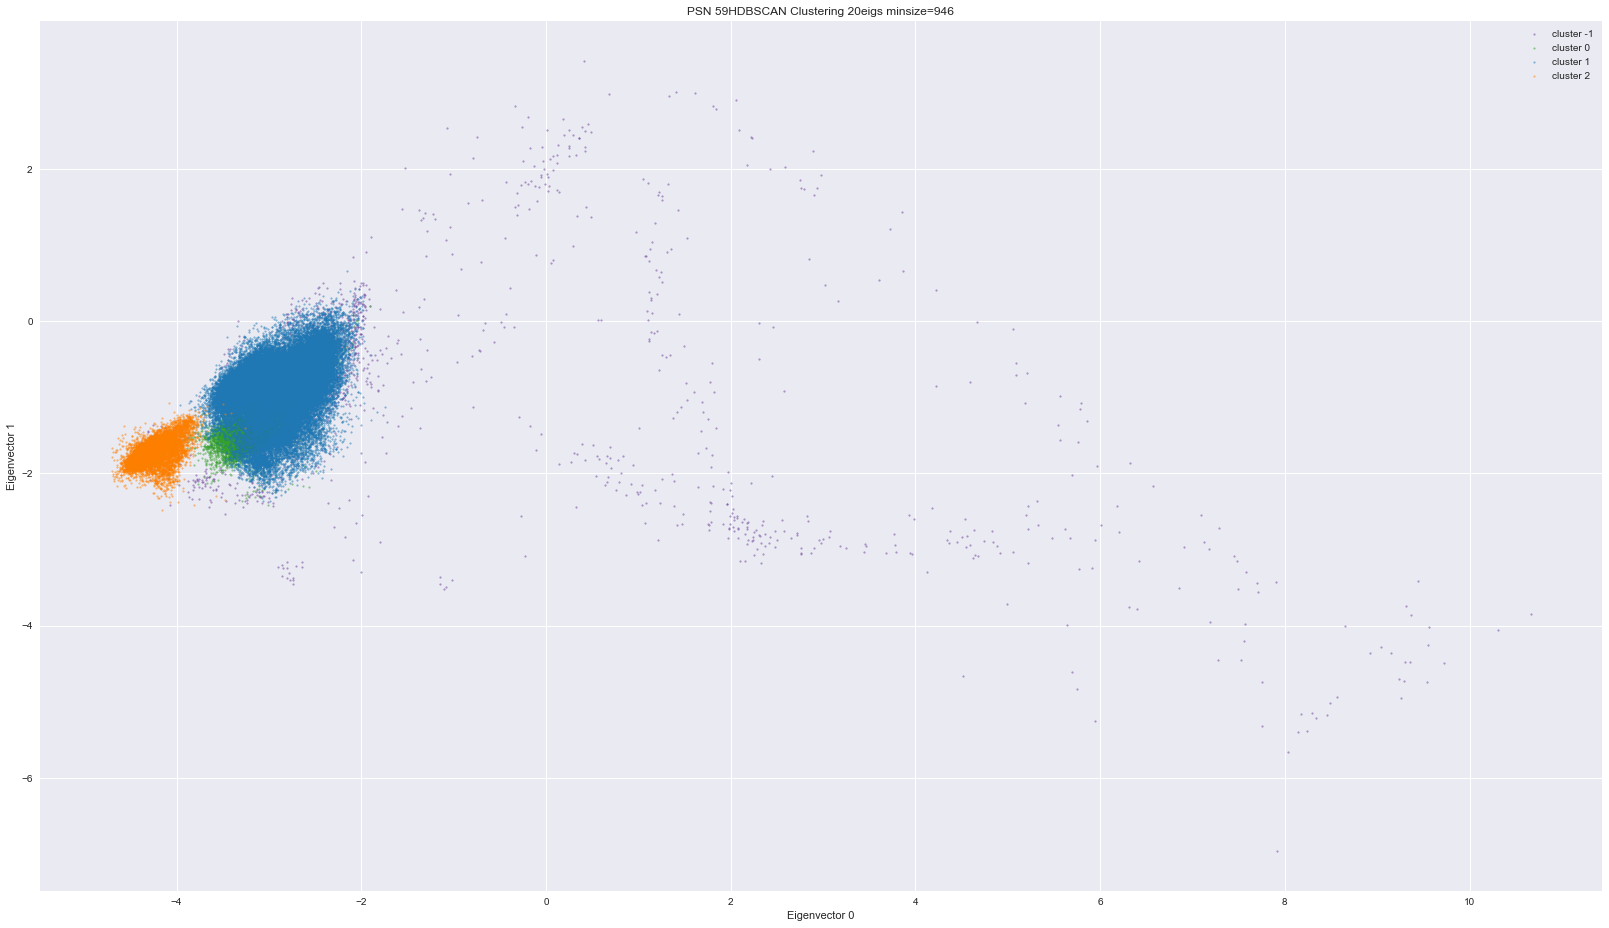

finished in total 48.66178321838379 seconds
started:  60
    clustering with min_cluster_size=386.....(27075, 72) 27075
finished in 10.936625719070435 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


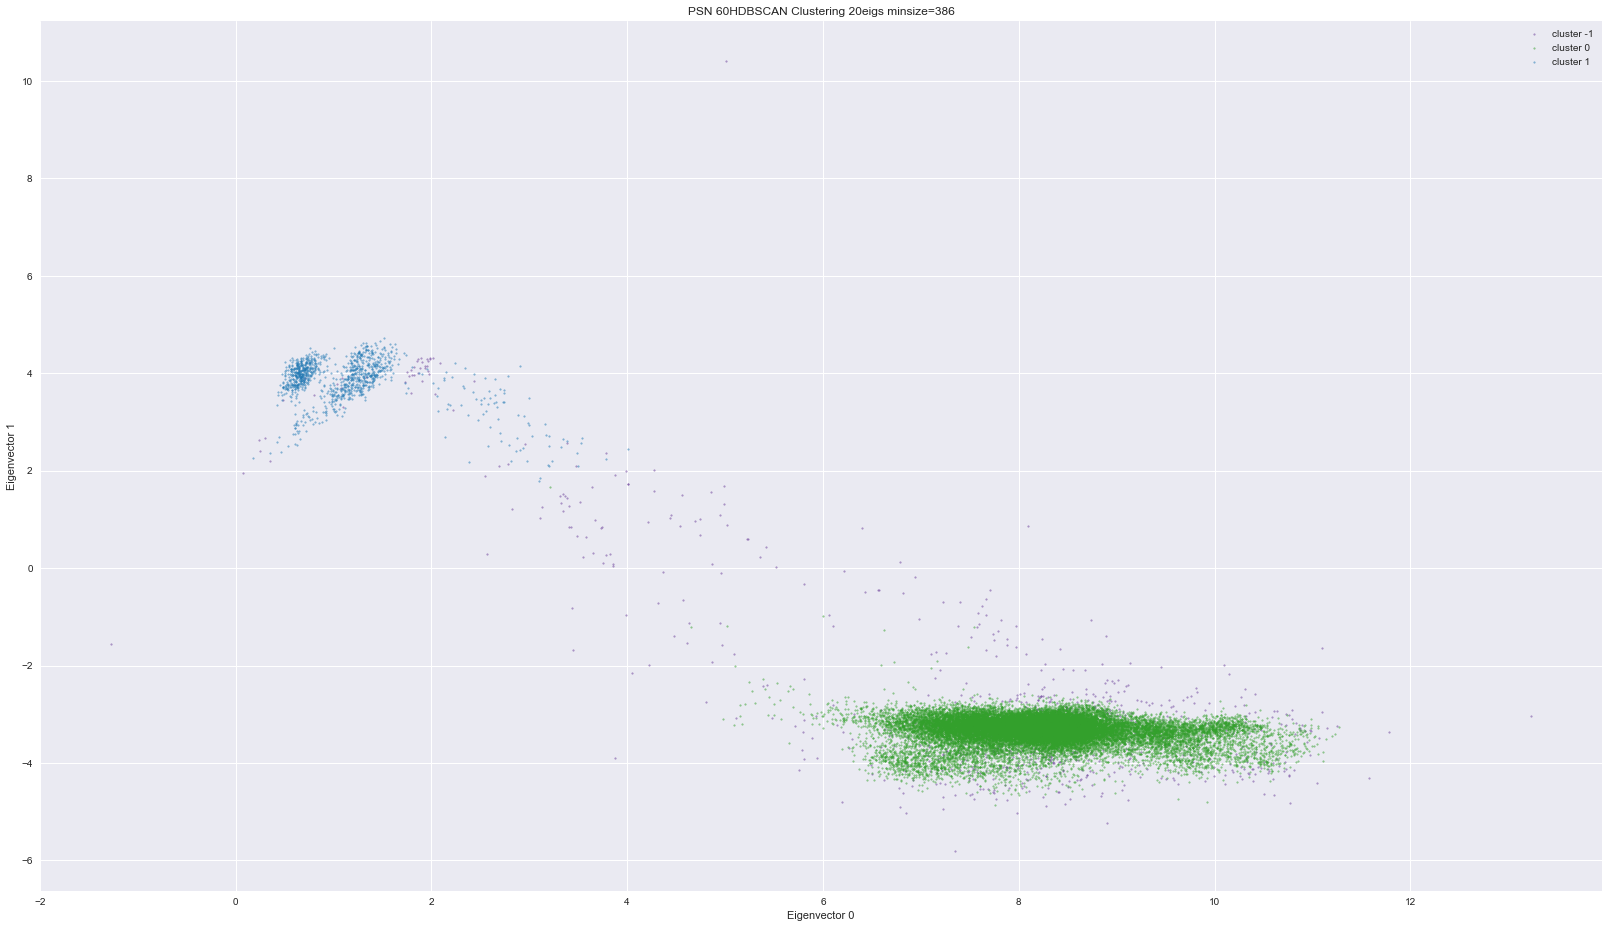

finished in total 11.823676586151123 seconds
started:  61
    clustering with min_cluster_size=246.....(17242, 72) 17242
finished in 5.864335298538208 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


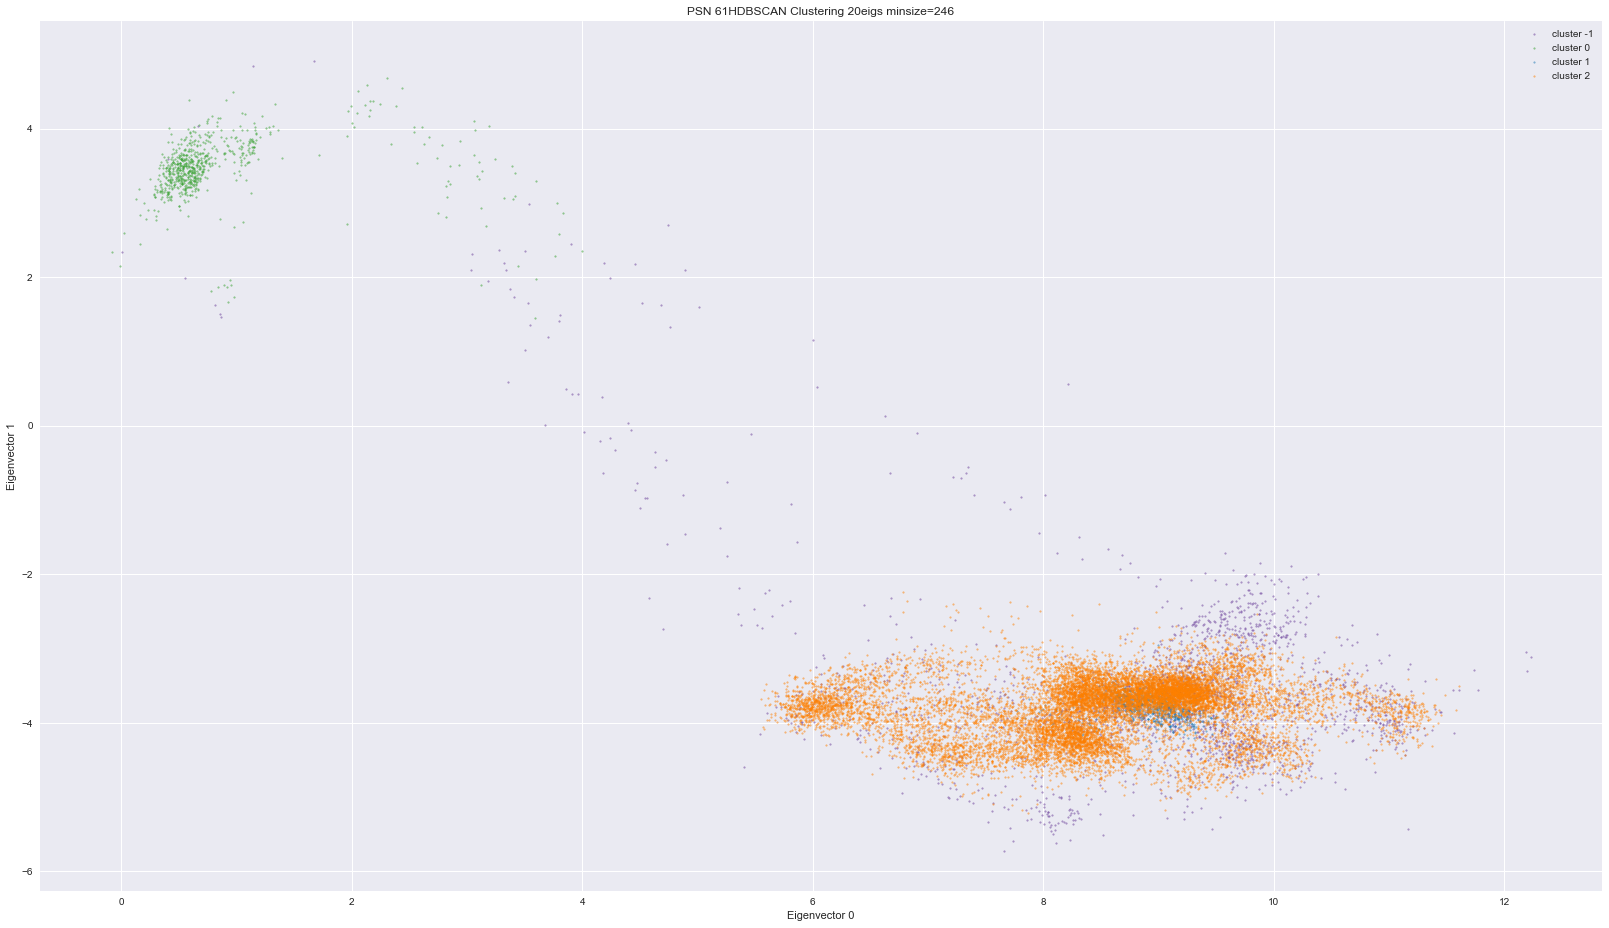

finished in total 6.6413798332214355 seconds
started:  62
    clustering with min_cluster_size=387.....(27185, 72) 27185
finished in 11.441654443740845 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


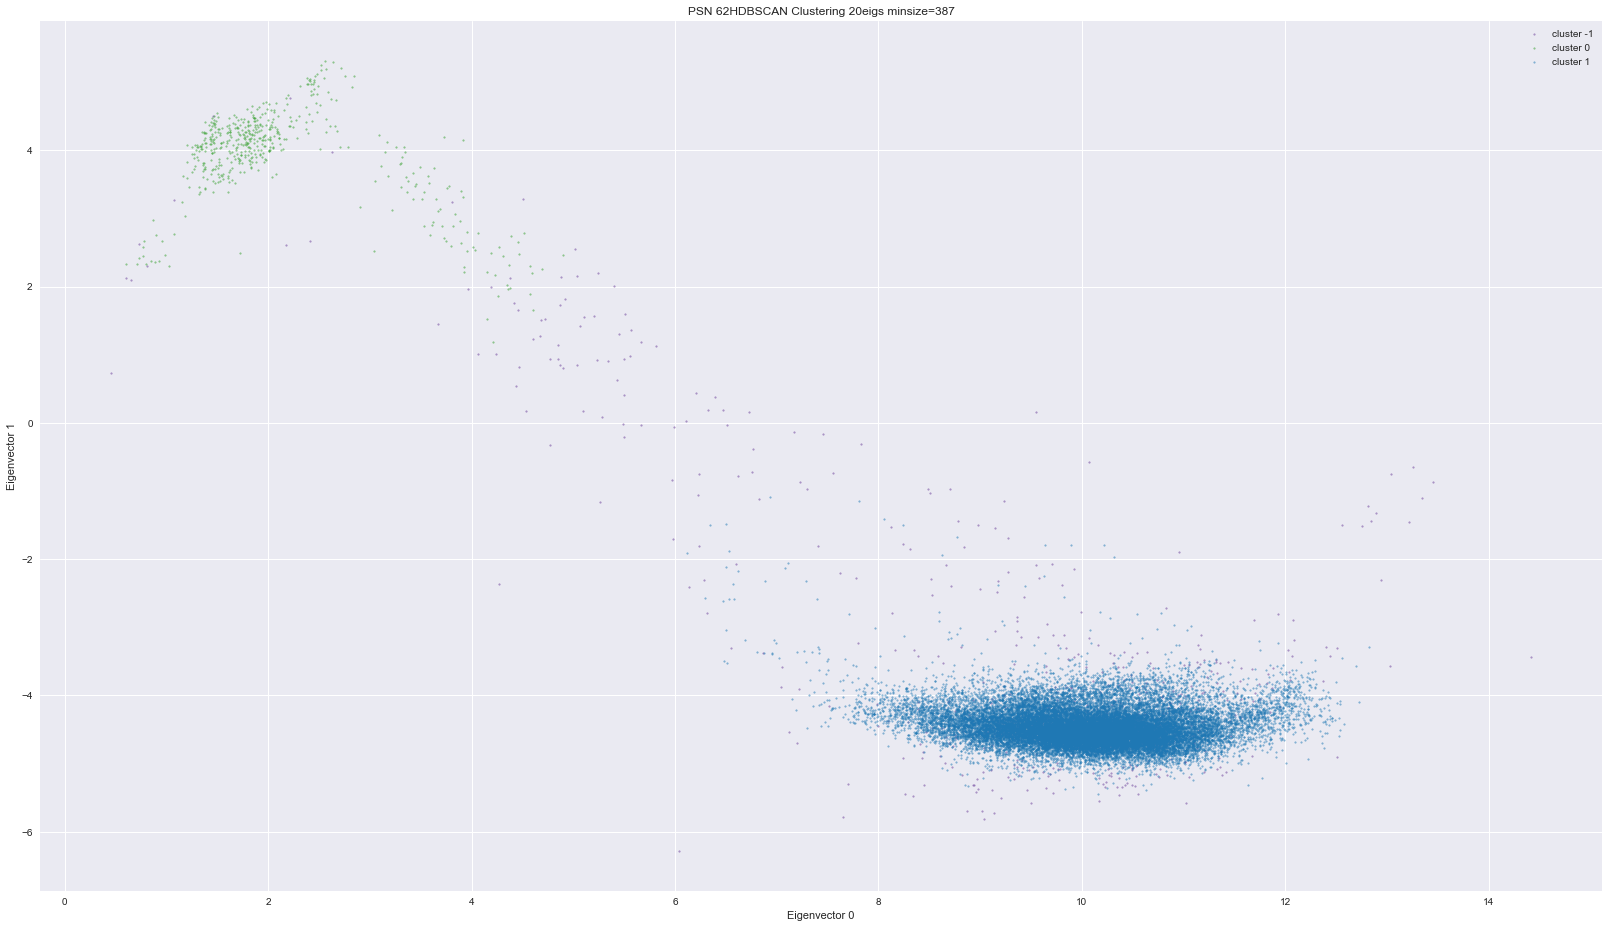

finished in total 12.322704792022705 seconds
started:  63
    clustering with min_cluster_size=19.....(1331, 72) 1331
finished in 0.07900452613830566 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


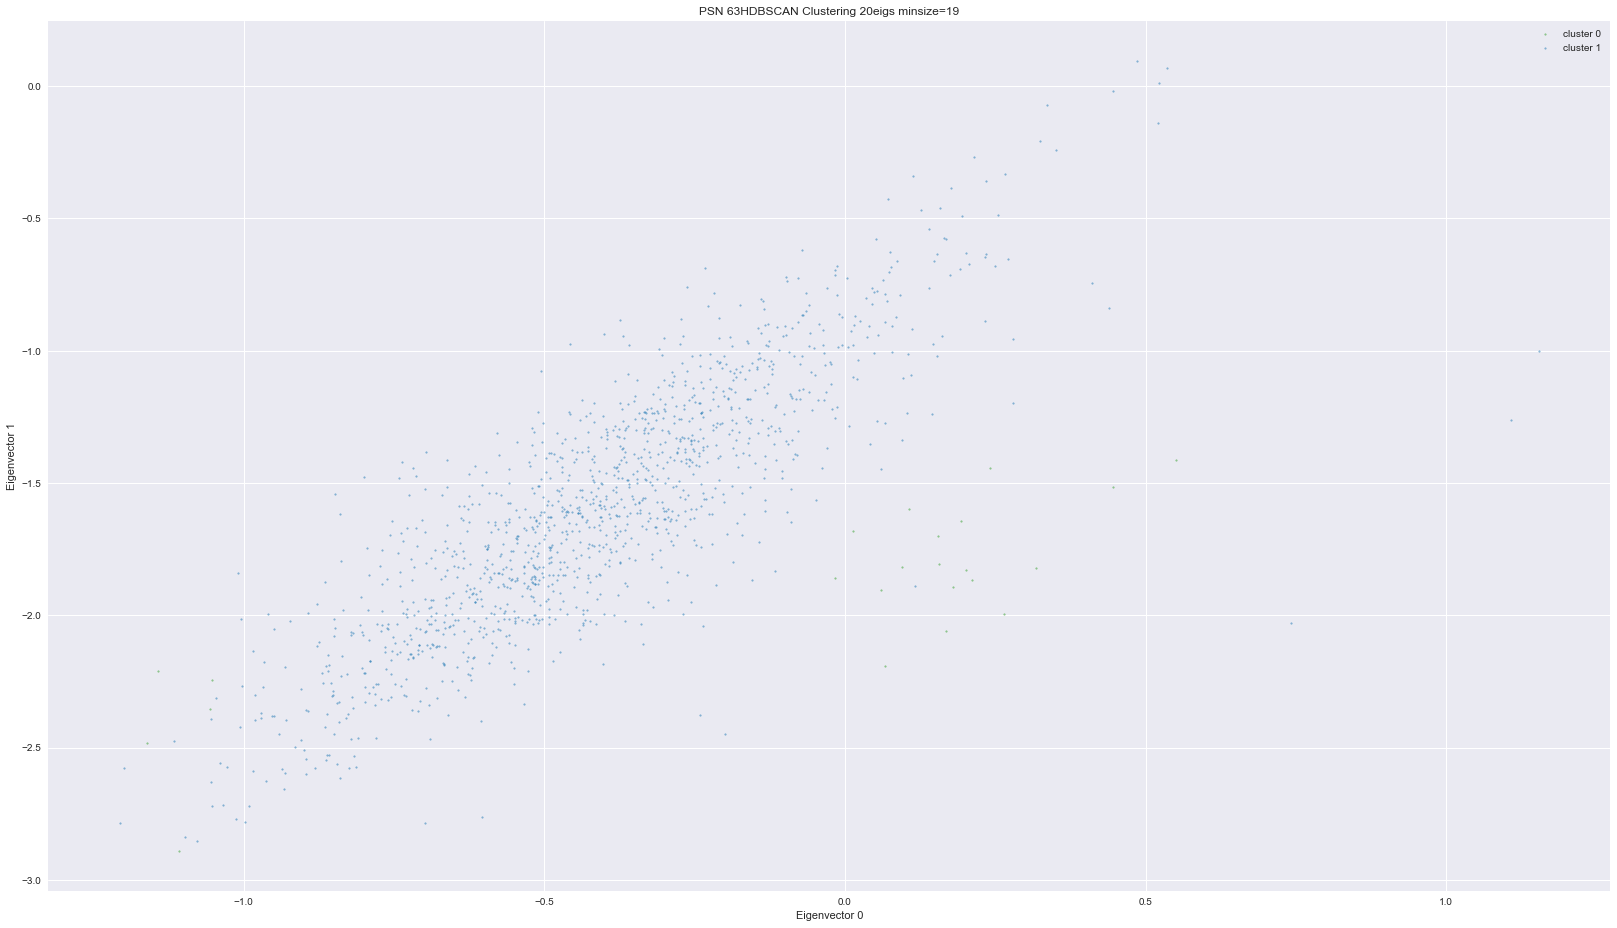

finished in total 0.6100349426269531 seconds
started:  64
    clustering with min_cluster_size=800.....(56204, 72) 56204
finished in 31.967828512191772 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


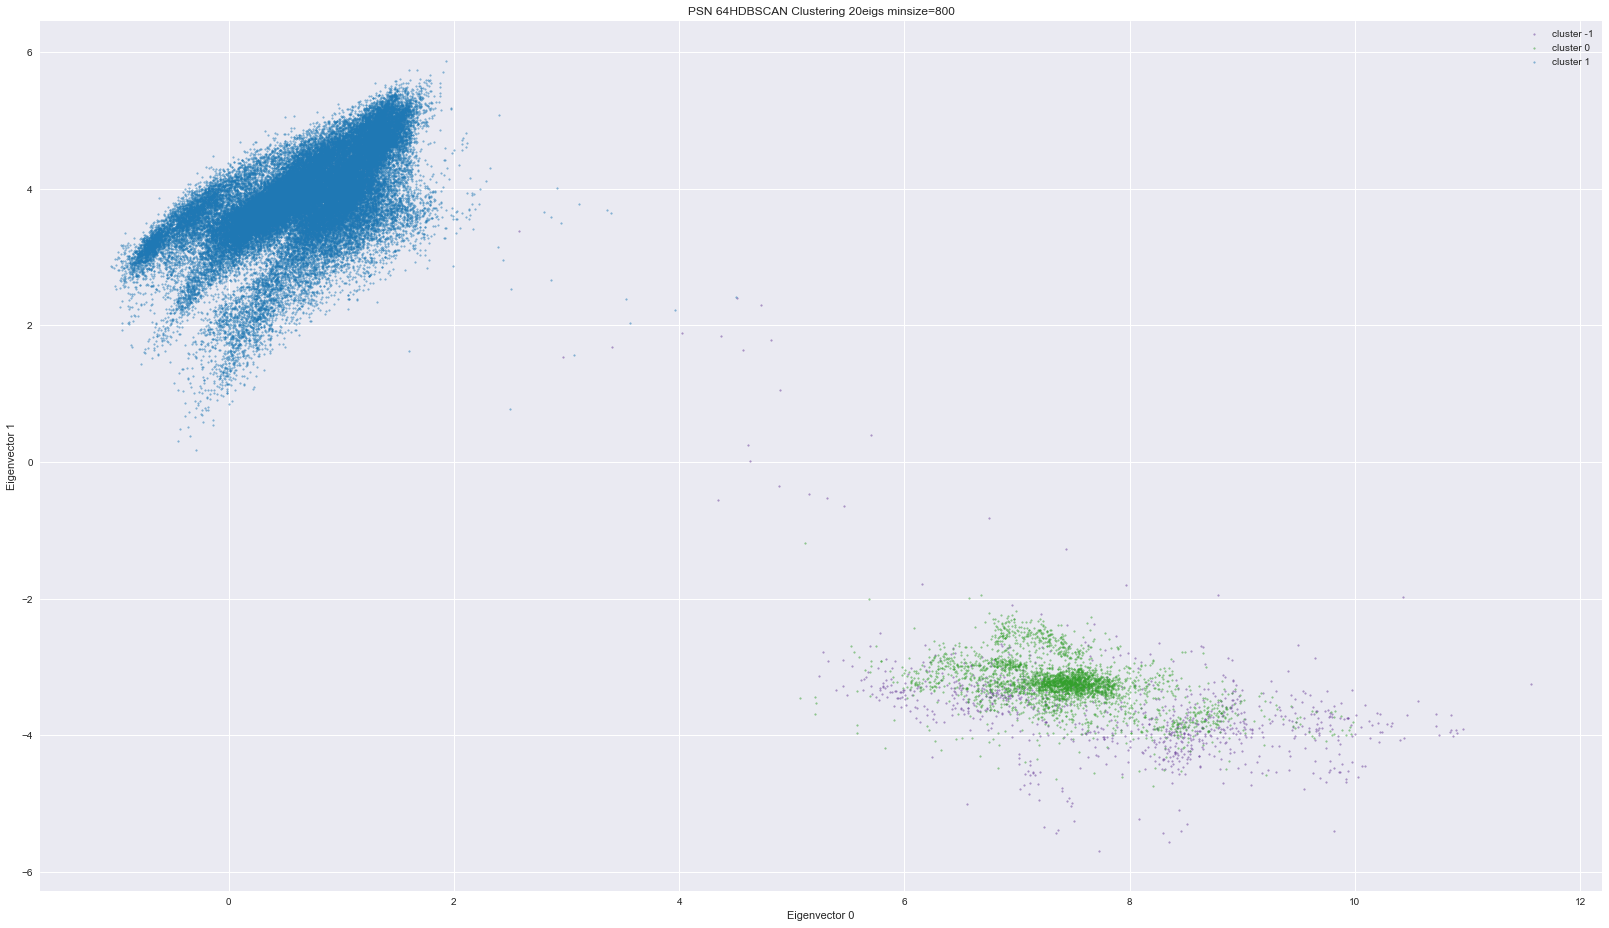

finished in total 33.25490212440491 seconds
started:  65
    clustering with min_cluster_size=727.....(51089, 72) 51089
finished in 26.872536659240723 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


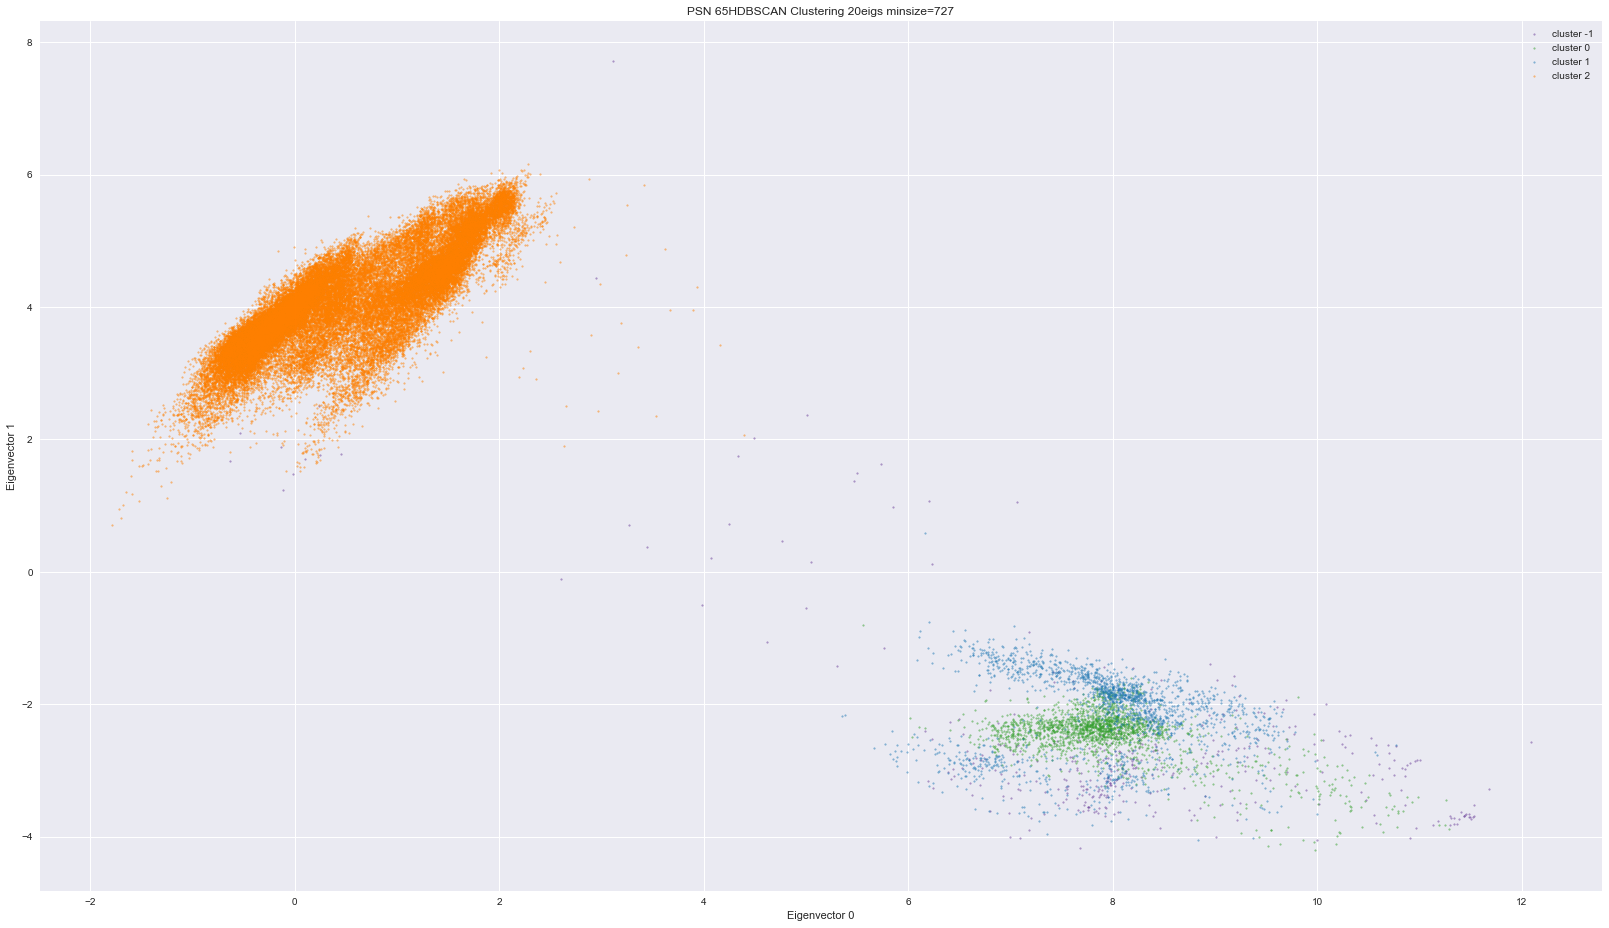

finished in total 28.08760643005371 seconds
started:  66
    clustering with min_cluster_size=849.....(59654, 72) 59654
finished in 42.17441201210022 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


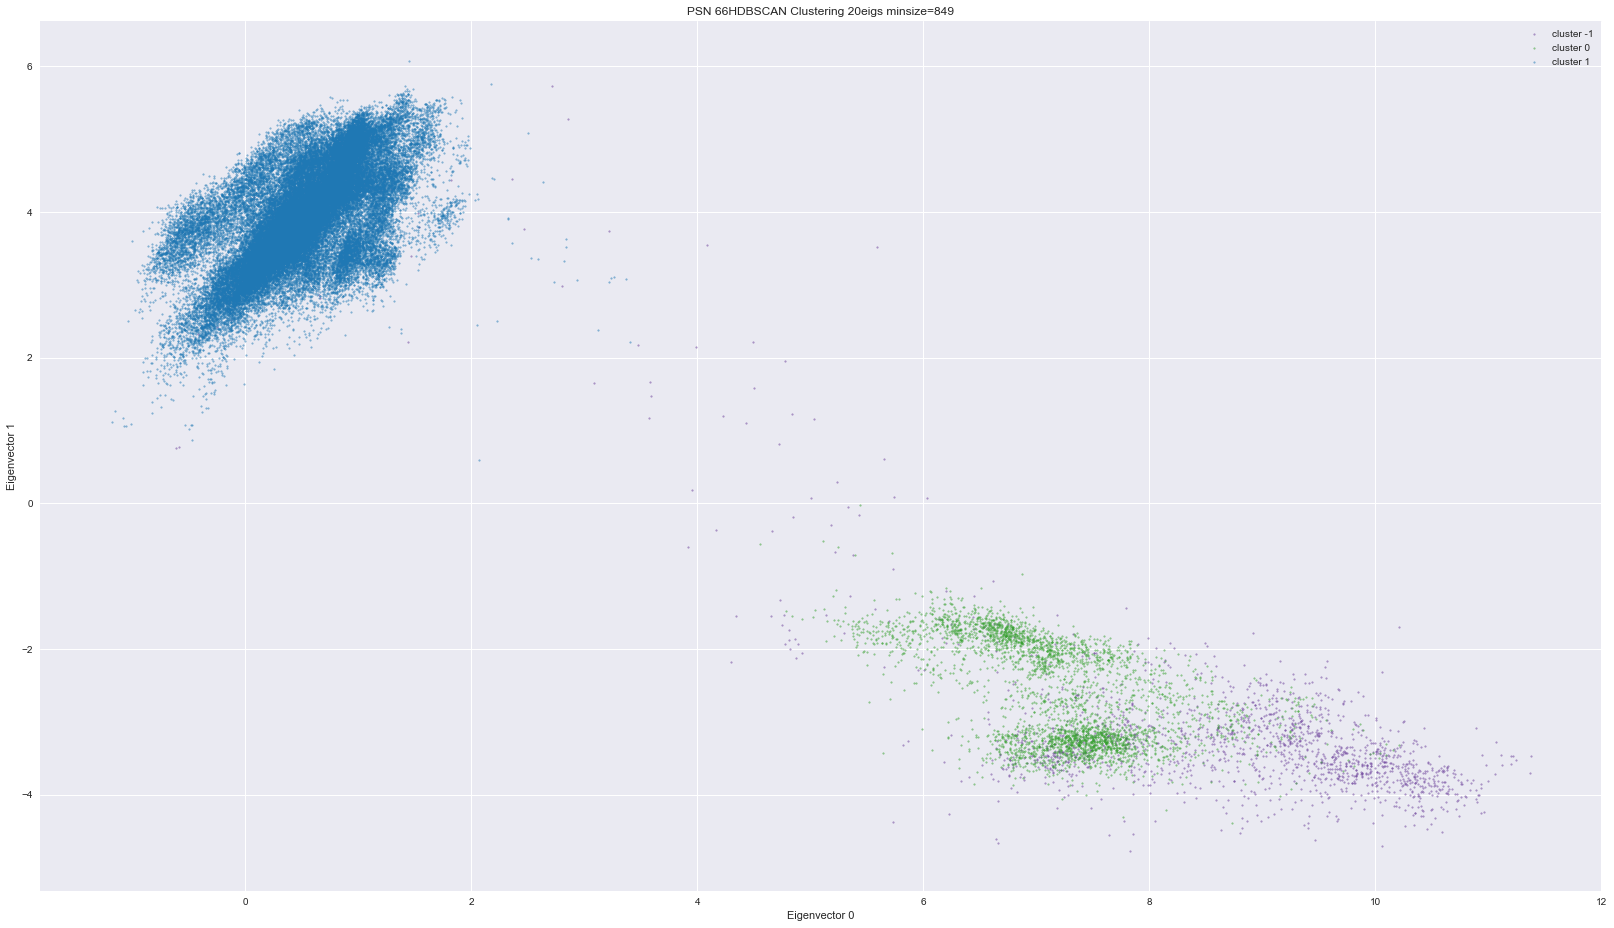

finished in total 43.489487409591675 seconds
started:  67
    clustering with min_cluster_size=816.....(57318, 72) 57318
finished in 39.10323667526245 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


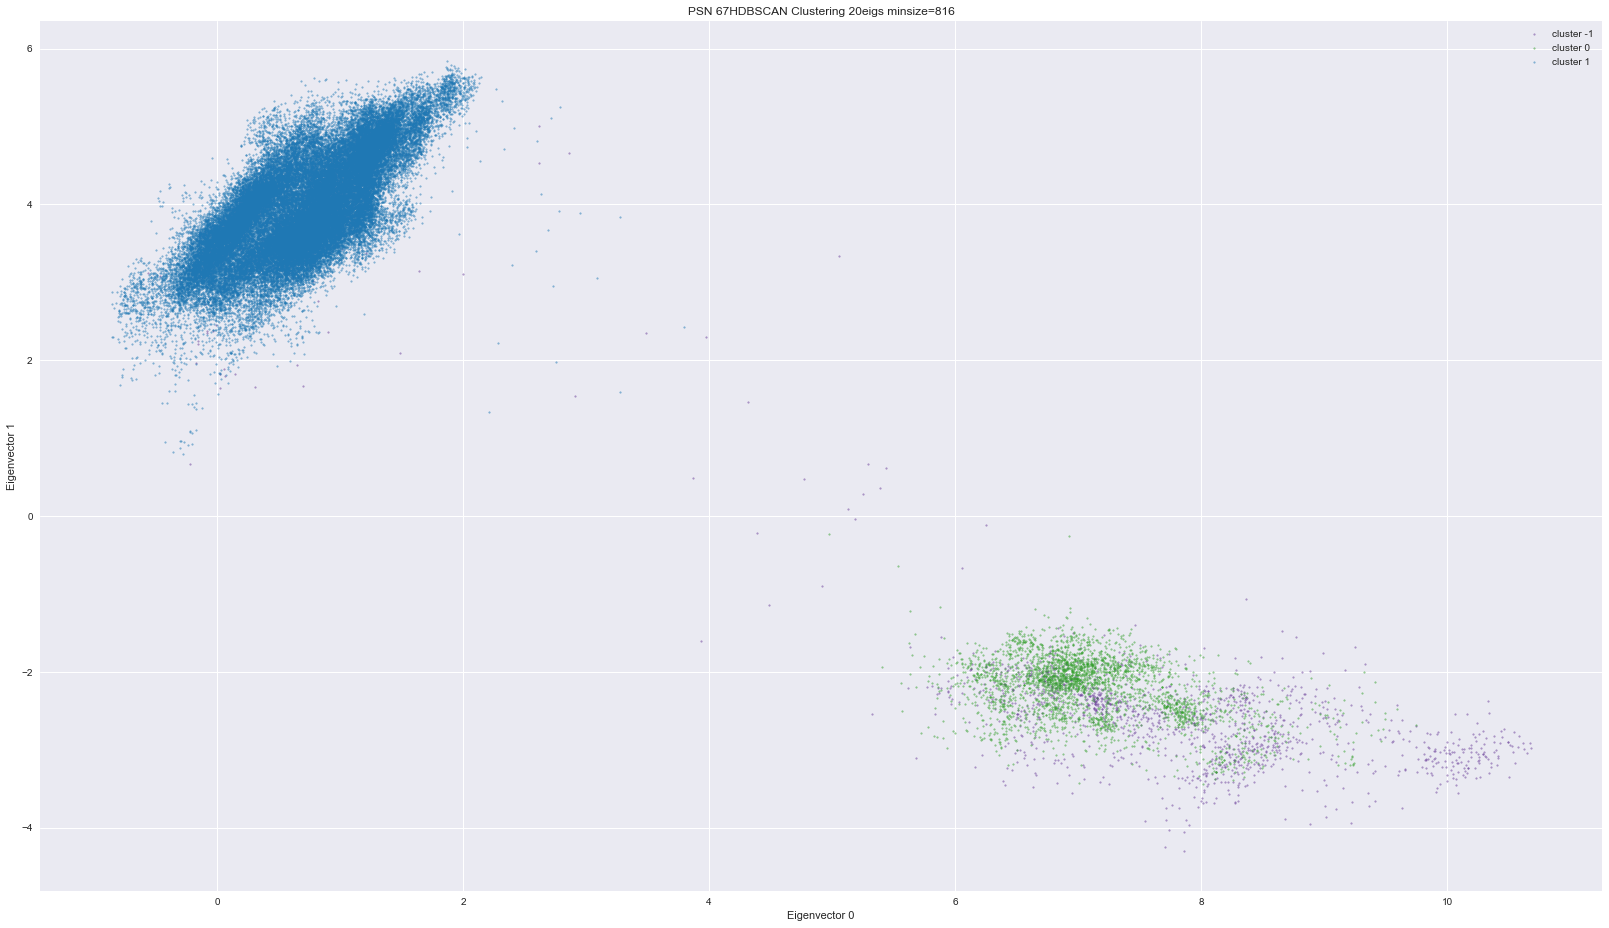

finished in total 40.37930965423584 seconds
started:  68
    clustering with min_cluster_size=1175.....(82581, 72) 82581
finished in 47.64572477340698 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


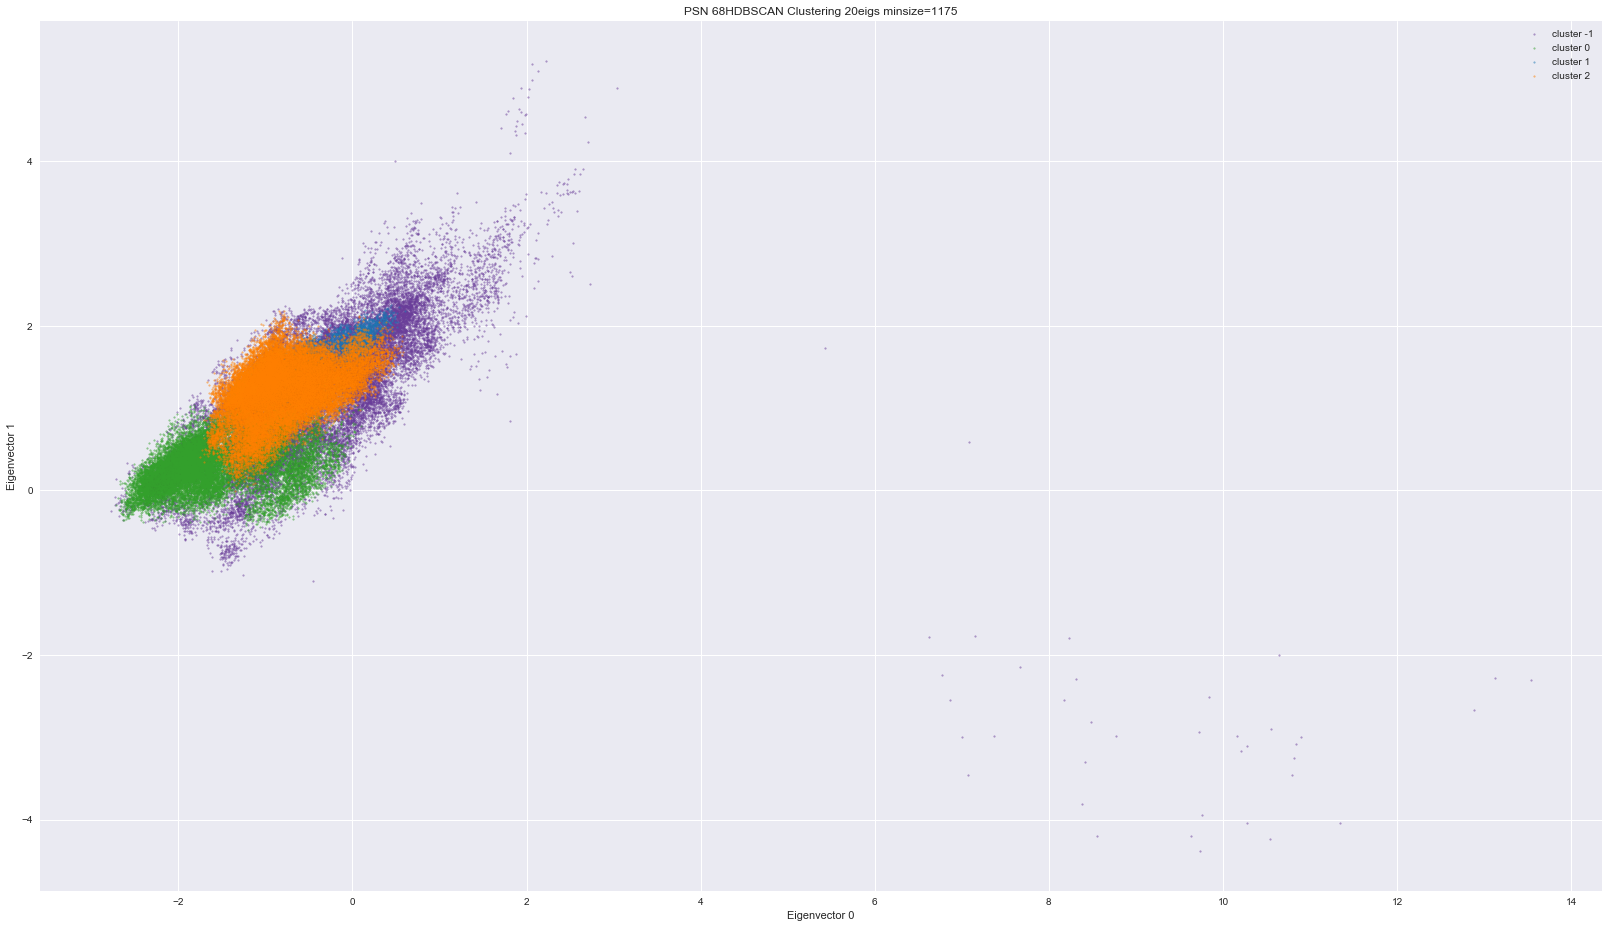

finished in total 49.238816261291504 seconds
started:  69
    clustering with min_cluster_size=184.....(12866, 72) 12866
finished in 3.69421124458313 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


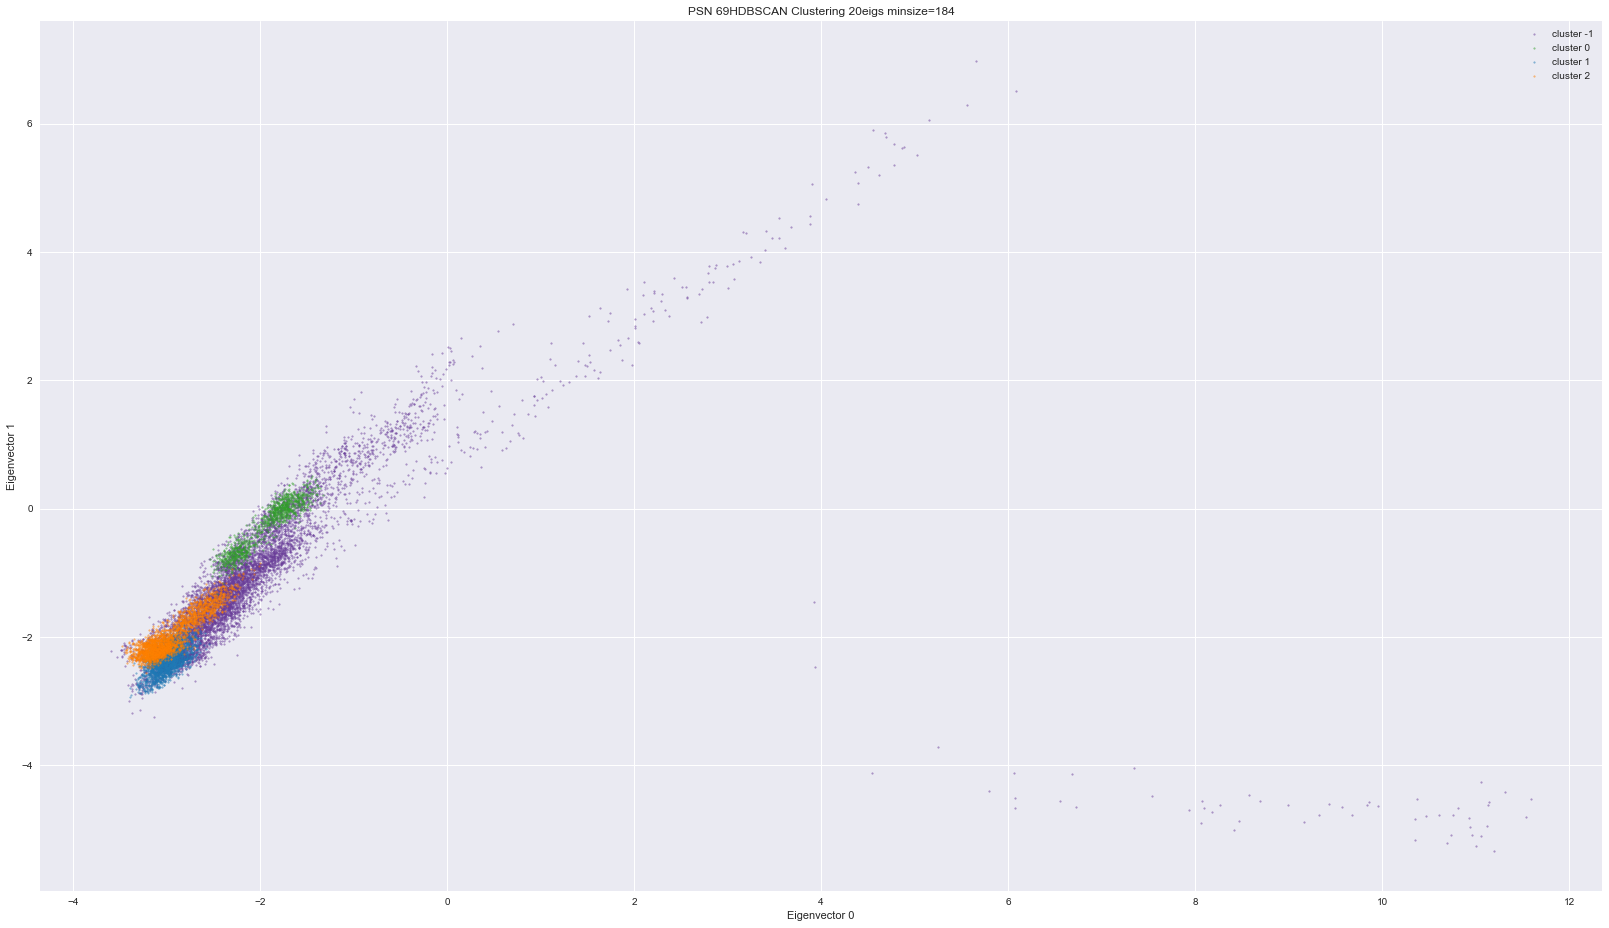

finished in total 4.40425181388855 seconds
started:  71
    clustering with min_cluster_size=325.....(22779, 72) 22779
finished in 8.65149474143982 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


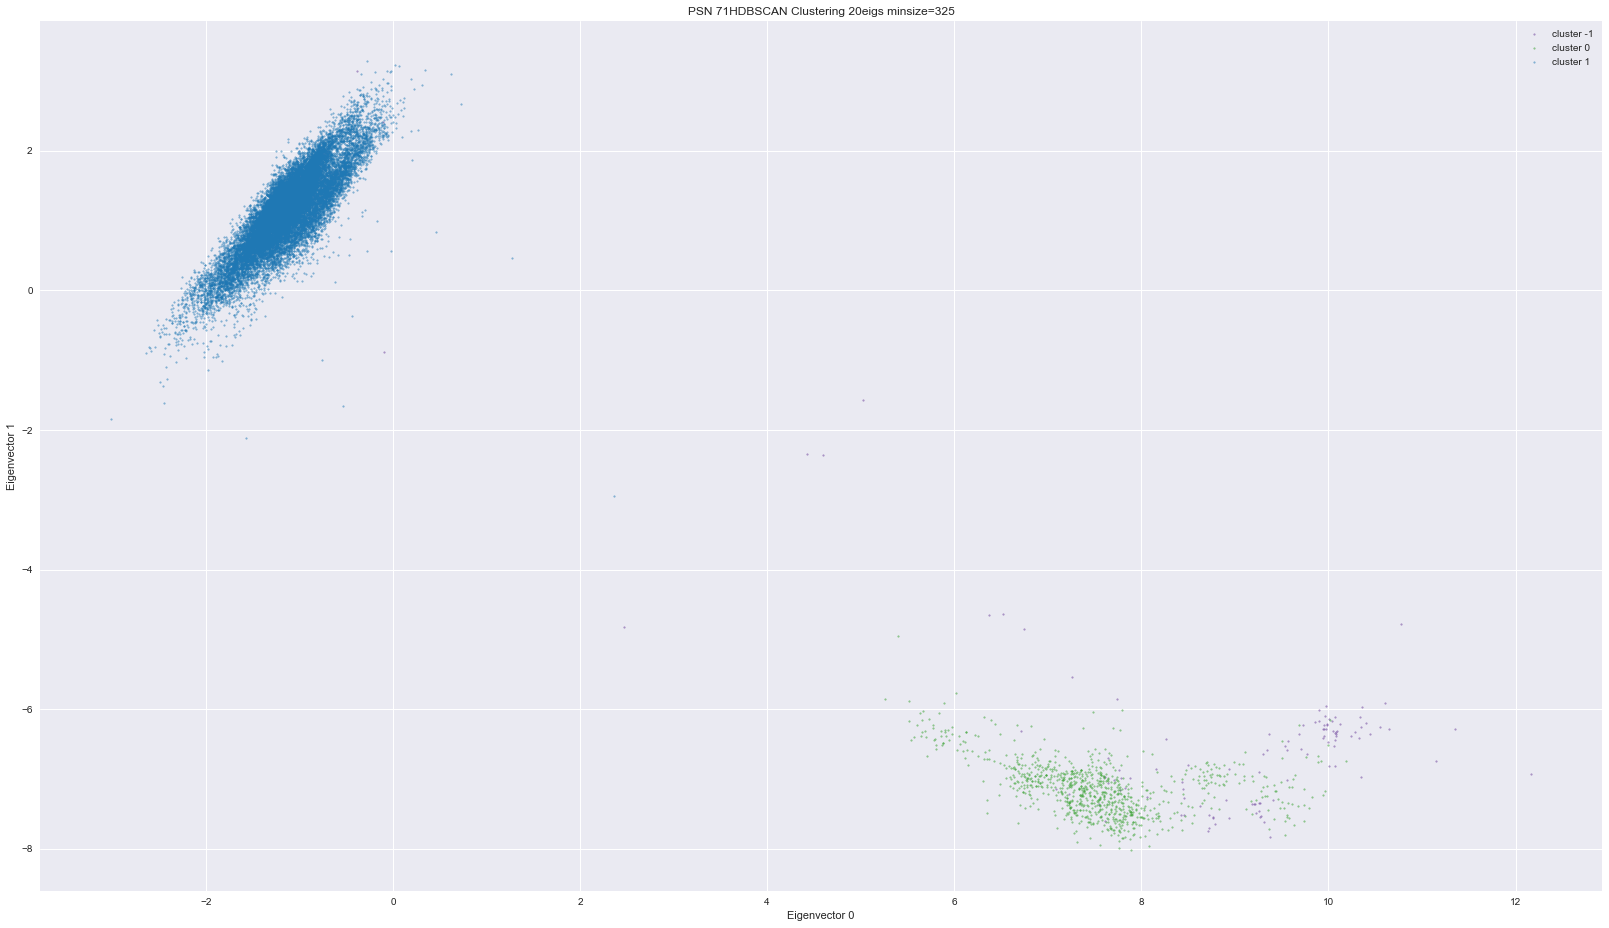

finished in total 9.469541549682617 seconds
started:  72
    clustering with min_cluster_size=794.....(55810, 72) 55810
finished in 35.062005281448364 seconds
    saving figure.....

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


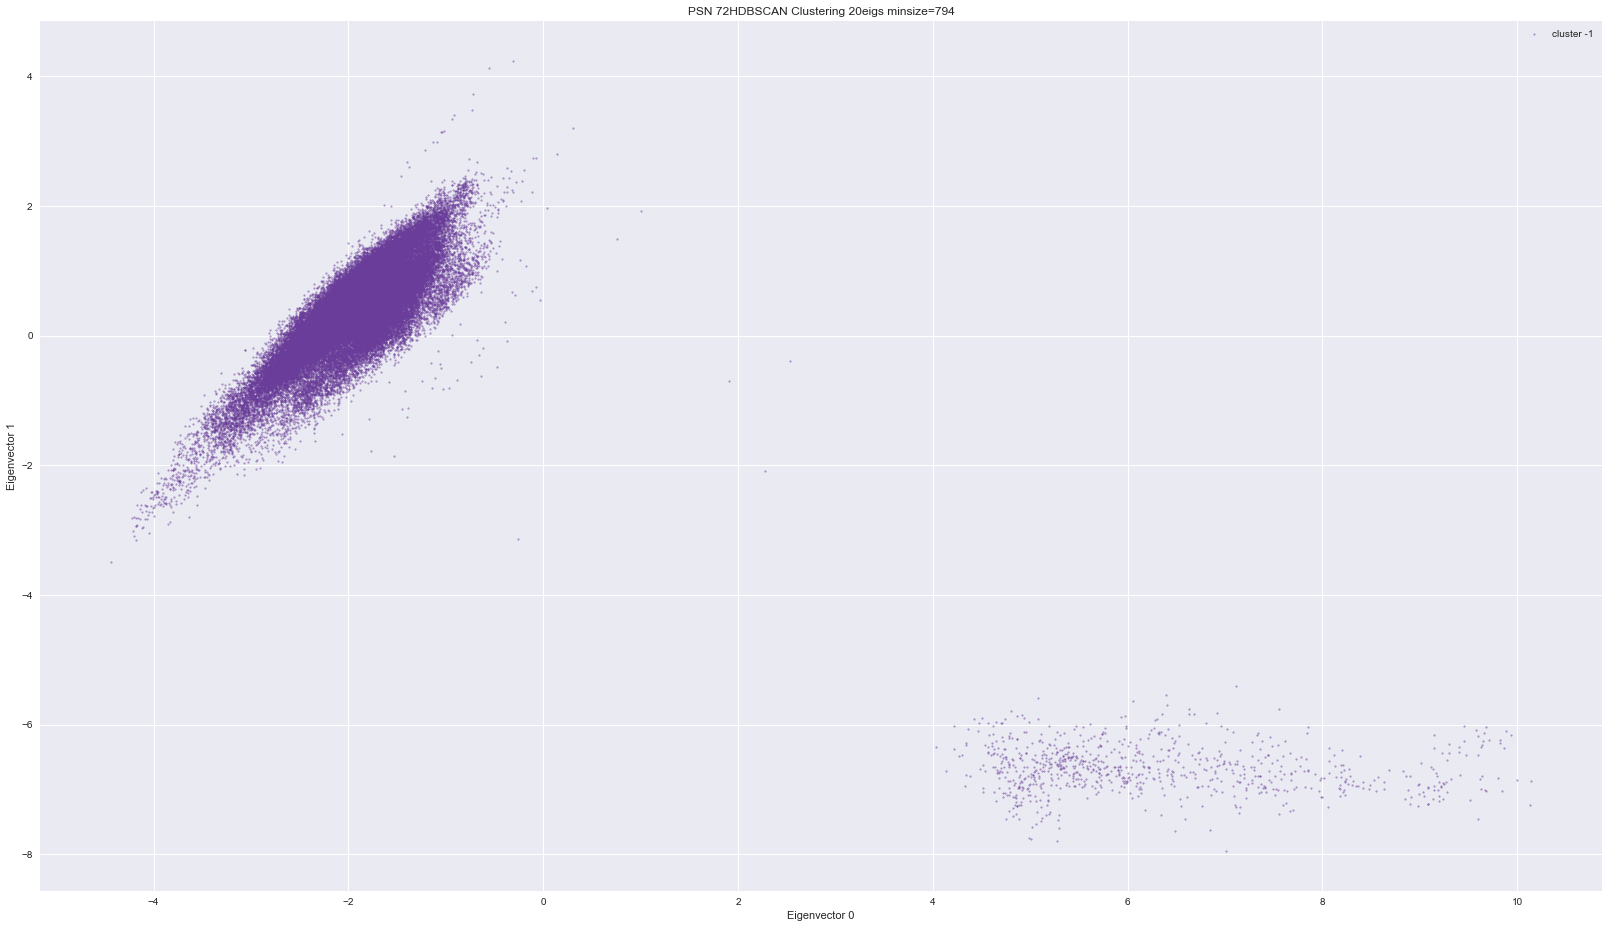

finished in total 36.313076972961426 seconds


In [58]:
num_eigs_toclust = 20 ## 20 eigenvectors cover 90% variance

current_directory = os.getcwd()
final_directory = os.path.join(current_directory,r'Hdbscan Clustering')
if not os.path.isdir(final_directory):
    os.mkdir(final_directory)

# for psn in sorted(rd_df['psn'].unique()):
# def clusterandplot(rd_df, psn, num_eigs_toclust):
for psn in sorted(rd_df['psn'].unique()):
    print('started: ',psn)
    nao = time.time()
    newdf = rd_df[rd_df['psn']==psn]
    min_clust_size = int(len(newdf)/70.3)+1
#     hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_clust_size) ## 70.3 chosen arbitrarily
    print('    clustering with min_cluster_size={}.....'.format(min_clust_size),end="",flush=True)
#     cluster_results = cluster_eigs(reduced_df=rd_df, psn=psn, cols=list(range(num_eigs_toclust)), cluster_algo=hdbscan)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_clust_size)
    clusterer_results = clusterer.fit_predict(newdf[list(range(num_eigs_toclust))])
    print(newdf.shape, len(clusterer_results))
    print('finished in {} seconds'.format(time.time()-nao))
    newdf['cluster'] = clusterer_results
    figname = 'PSN '+str(psn)+'HDBSCAN Clustering 20eigs minsize='+str(min_clust_size)
    print('    saving figure.....',end="",flush=True)
    plot_clusters(newdf, x=0, y=1, colorpal = color_pal, save_fig=True, directory=final_directory+'\\', title = figname)
    print('finished in total {} seconds'.format(time.time()-nao))


In [27]:
newdf.shape

(89536, 72)

In [28]:
len(clusterer_results)

103217

In [52]:
reduced_onepsn = rd_df[rd_df['psn']==49]
print(reduced_onepsn.shape)
# raw_data_psn46 = model2_10min[model2_10min['psn']==46]
# joined_psn46 = model2  data[index_cols].merge(top20_reduced, left_on='id', right_on='id')

(89536, 72)


In [53]:
## perhaps subset to top 20 eigenvectors???
nao = time.time()
no_clusts = 3
num_eigs_toclust = 20
clusterer = hdbscan.HDBSCAN(min_cluster_size=1273) #### i think we're onto something here. ## min cluster size roughly around number of row divided by 45. minimum min_cluster_size?????
clusterer_results = clusterer.fit_predict(reduced_onepsn[list(range(num_eigs_toclust))])
# kmeans = KMeans(init='k-means++', n_clusters=no_clusts, n_init=10)
# kmeans_results = kmeans.fit_predict(reduced_onepsn[list(range(num_eigs_toclust))]) ## returns a 1-d array of which cluster each row is in

# Dbscan = DBSCAN(eps=5, min_samples=no_clusts)
# dbscan_results = Dbscan.fit_predict(reduced_onepsn[list(range(num_eigs_toclust))]) ## returns a 1-d array of which cluster each row is in

## clusters all rows, only columns 0 to from num_eigs_toclust (excludes the id,psn,timestamp cols)

# agglom_ward_results = Agglom_ward.fit_predict(reduced_onepsn[list(range(num_eigs_toclust))])
# GMM_diag.fit(reduced_onepsn[list(range(num_eigs_toclust))])
# gmm_results = GMM_diag.predict(reduced_onepsn[list(range(num_eigs_toclust))])

print(Counter(clusterer_results))
# print(Counter(dbscan_results))
print(time.time()-nao)

Counter({1: 53985, 2: 30526, -1: 2711, 0: 2314})
61.48951697349548


In [54]:
reduced_onepsn['cluster'] = clusterer_results#agglom_ward_results#dbscan_results

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


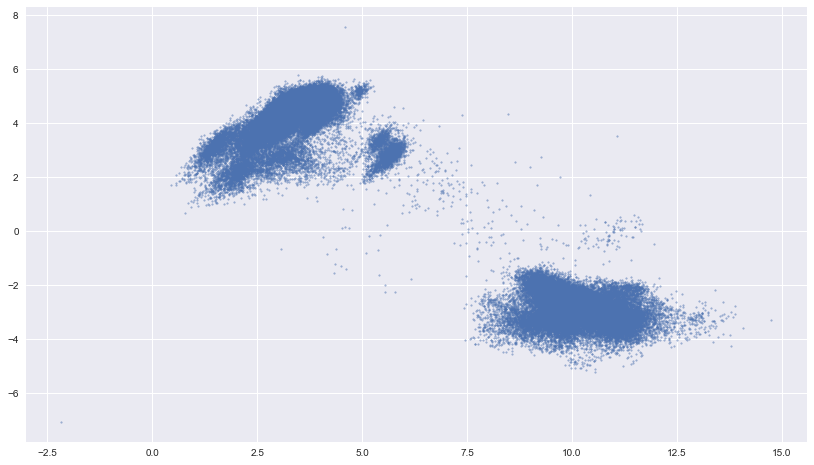

In [55]:
plt.figure(figsize=(14,8))
plt.scatter(reduced_onepsn[0].values,reduced_onepsn[1].values,s=3,alpha=0.5)
plt.show()

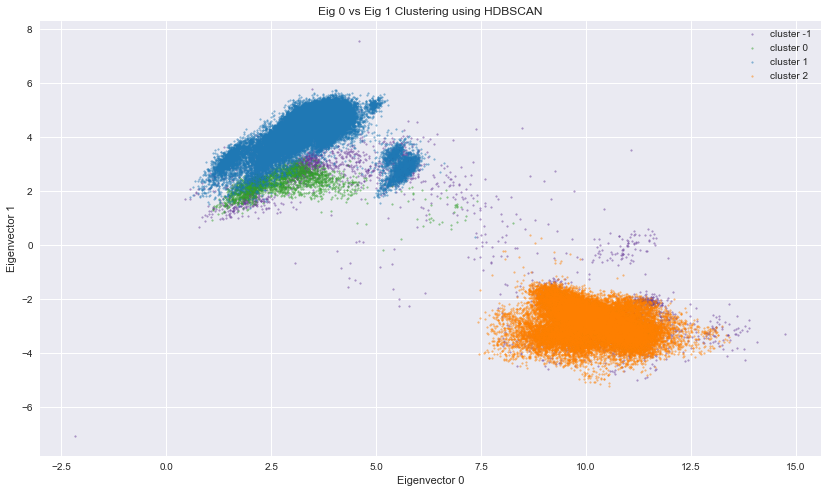

In [56]:
### HDBSCAN with min_samples=2000
plt.figure(figsize=(14,8))
for i in sorted(reduced_onepsn['cluster'].unique()):
    tempdf = reduced_onepsn[reduced_onepsn['cluster']==i]
    plt.scatter(tempdf[0].values,tempdf[1].values,s=3,alpha=0.5,c=color_pal[i],label = 'cluster '+str(i))
plt.xlabel('Eigenvector 0')
plt.ylabel('Eigenvector 1')
plt.title('Eig 0 vs Eig 1 Clustering using HDBSCAN')
plt.legend()
# plt.show()
# plt.savefig('Eig 0 vs Eig 1 Clustering using HDBSCAN 20eigs.png')
plt.show()